<a href="https://colab.research.google.com/github/bowen27/Swamp-World/blob/main/Copy_of_ParameterTest02052025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌿 **Modeling Swamps: A Case Study**

## **Introduction**
In this notebook, we explore a **difficult swamp modeling scenario** using a planet with:
- **Low Global Equivalent Water Layer (GEL = 500 m)**  
- **Low Hydraulic Conductivity (K = 1e-5 m/s)**  

---

## **Notebook Structure**
We analyze the **three key components** of swamp formation:
1. **Initialization**
2. **Shoreline Evolution**  
3. **Swamp Evolution**  





In [4]:
!python --version

Python 3.11.11


In [1]:
## Functions
from keyword import kwlist
import numpy as np
import matplotlib.pyplot as plt
import time
import h5py
import warnings

# Set the default print options for NumPy arrays to use scientific notation
np.set_printoptions(formatter={'float': '{:0.2e}'.format})

def generate_topography(phi, choice='Uniform', height=5e3, half_width=30):
    """
    Generate synthetic planetary topography based on the specified choice.

    Parameters:
        phi : ndarray
            Array of co-latitudes (in radians).
        choice : str, optional
            The type of topography to generate. Options are:
            'Uniform', 'Sin', 'Step', 'NegativeSlope', 'PositiveSlope', 'Gaussian', 'GaussianWithHole'.
        height : float, optional
            The maximum height of the topographical features (default is 5000 m).
        half_width : float, optional
            The half-width parameter for certain topography types (default is 30 degrees).

    Returns:
        topo : ndarray
            Generated topography values corresponding to the input co-latitudes.
    """
    phi_deg = np.degrees(phi)

    match choice:
        case "Uniform":
            return np.zeros_like(phi)
        case "Sin":
            return height * np.sin(1 * phi)
        case "Step":
            return np.where((90 - half_width <= phi_deg) & (phi_deg <= 90 + half_width), height, 0)
        case "NegativeSlope":
            return np.linspace(height, 0, len(phi))
        case "PositiveSlope":
            return np.linspace(0, height, len(phi))
        case "Gaussian":
            return height * np.exp(-((phi_deg - 90) ** 2) / (2 * half_width ** 2))
        case "GaussianWithHole":
            depression_height = 3e3
            depression_width = 10
            topo = height * np.exp(-((phi_deg - 90) ** 2) / (2 * half_width ** 2))
            depression = depression_height * np.exp(-((phi_deg - 90) ** 2) / (2 * depression_width ** 2))
            return topo - depression
        case _:
            raise ValueError(f"Invalid topography choice: {choice}")

def initialize_model(params):
    """Initialize model parameters, grid, and initial conditions."""

    # Compute grid
    dphi = np.radians(params["latitude_degree"])  # Define dphi inside the function
    phi = np.radians(np.arange(params["latitude_degree"] / 2, 180 + params["latitude_degree"] / 2, params["latitude_degree"]))
    latitude = np.degrees(phi) - 90  # Convert co-latitude to latitude (-90° to 90°)
    phi_deg = np.degrees(phi)

    # ✅ Use topography parameters from `params`
    topo = generate_topography(phi, choice=params["topo_choice"], height=params["topo_amplitude"])

    # Compute initial water distribution
    wet_idx, water_level = estimate_wetness_initial(phi, params["I"], params["n_s"], topo, params["r"], params["K_poro"])

    # Compute initial precipitation & evaporation
    evap_ini = calculate_evaporation(phi, topo, wet_idx, params["S"], params["r"])
    precip_ini = calculate_precipitation(phi, evap_ini, params["extreme_index"], spatial_assumption="local", ITCZ_range=params["moisture_transport"])

    # Ensure `h_ini` is the same length as latitude
    h_ini = np.full_like(latitude, water_level)

    # Determine if further evolution is needed
    fully_ocean = np.all(wet_idx == 0)  # Entire planet is covered by water
    fully_dry = np.all(wet_idx < 0)     # Entire planet is dry

    return phi, latitude, dphi, phi_deg, topo, h_ini, wet_idx, precip_ini, evap_ini, fully_ocean, fully_dry

def estimate_wetness_initial(phi, I, n_s, topo, r, K_poro):
  """
  Estimate the initial wetness distribution on the planetary surface and subsurface.

  Parameters:
  phi : ndarray
      Array of co-latitudes (in radians).
  I : float
      Total water inventory available.
  n_s : float
      Porosity of the subsurface material.
  topo : ndarray
      Array representing the planetary topography.
  r : float
      Planetary radius.
  K_poro : float
      Hydraulic conductivity parameter for porosity.

  Returns:
  wet_idx : ndarray
      Array indicating the wetness status of each location (negative = water below surface, 0 = wet).
  water_level : float
      The level of water at the end of the simulation.
  """

  # Convert co-latitudes from radians to degrees
  phi_deg = np.degrees(phi)

  dphi = np.radians(params["latitude_degree"])  # Define dphi inside the function

  # revise the topography to be always above zero
  revised_topo = topo - topo[np.argmin(topo)]

  # Initialize wetness index (0 = dry) and residual water inventory
  # wet_idx = np.zeros_like(topo)
  residual_I = I
  wet_surface = False
  water_world = False

  # Iterate until water runs out or the planet becomes completely covered (water-world)
  while residual_I > 0 and not water_world:
    # First stage: All water within the subsurface
    ddepth = 1e0  # Step size for depth iteration (1000 m)
    depth = np.arange(-2e4, -1 * ddepth + 1, ddepth)  # Depths from -20000 m to just below the surface
    depth_volume = np.zeros_like(depth)

    for current_depth in depth:
      # Calculate local depth relative to the revised topography
      local_depth = current_depth - revised_topo
      # Calculate local porosity based on exponential decay with depth
      local_n = n_s * np.exp(local_depth / K_poro)
      # Calculate the volume of water at the current depth
      local_volume = local_n * 2 * np.pi * r**2 * np.cos(np.radians(phi_deg-90)) * dphi * ddepth
      depth_volume = np.sum(local_volume)
      # Subtract the calculated volume from the residual water inventory
      residual_I = residual_I - depth_volume

      # Check if water runs out at the current depth
      if residual_I <= 0:
        message = f"Run out of water in the subsurface at depth = {current_depth} m! The planet is hyper-arid."
        print(message)
        water_level = current_depth
        break
      # If all depths are reached, move to surface wetting stage
      elif current_depth == np.max(depth):
        wet_surface = True

    # Second stage: Surface partially covered by liquid water
    if wet_surface:
      dheight = (np.max(revised_topo) - np.min(revised_topo)) / 50  # Step size for height iteration
      height = np.arange(np.min(revised_topo), np.max(revised_topo) + 1, dheight)
      height_volume = np.zeros_like(height)

      for current_height in height:
        # Calculate local height relative to the revised topography
        local_height = current_height - revised_topo
        # Calculate local porosity and set to 1 for above-surface water
        local_n = n_s * np.exp(local_height / K_poro)
        local_n[local_height >= 0] = 1
        # Calculate the volume of water at the current height
        local_volume = local_n * 2 * np.pi * r ** 2 * np.cos(np.radians(phi_deg-90)) * dphi * dheight
        height_volume = sum(local_volume)
        # Subtract the calculated volume from the residual water inventory
        residual_I = residual_I - height_volume

        # Check if water runs out at the current height
        if residual_I <= 0:
          message = f"Run out of water with surface ocean at height = {current_height} m!"
          print(message)
          # wet_idx[local_height >= 0] = 1
          water_level = current_height
          break
        # If all heights are covered, declare the planet a water-world
        elif current_height == np.max(revised_topo):
          print("The planet is a water-world!")
          # wet_idx[:] = 1
          water_level = current_height + residual_I / (4*np.pi*r**2)
          water_world = True
          break

  wet_idx = np.minimum(np.zeros_like(phi), water_level - topo)
  # wet_idx = water_level - topo

  return wet_idx, water_level

def calculate_evaporation(phi, topo, wet_idx, S, r):
  """
  Calculate the evaporation rate based on latitude, topography, and wetness index.

  Parameters:
  phi : ndarray
      Array of co-latitudes (in radians).
  topo : ndarray
      Array representing the planetary topography.
  wet_idx : ndarray
      Array indicating the current wetness status of each location.
  S : float
      Solar constant representing incoming solar radiation.
  r : float
      Planetary radius.

  Returns:
  evap : ndarray
      Array representing the evaporation rate at each latitude.
  """

  # Base evaporation rate in m/s (converted from mm/day)
  evap0 = 3                         # Initial evaporation rate in mm/day
  # evap0 = 0.002
  evap0 = evap0 * 1e-3 / (24 * 3600)  # Unit conversion to m/s

  k_GE = 1     # Groundwater decay (m)

  # Choice 0: Set evaporation rate to zero for dry regions (wet_idx = 0)
  # wet_idx = np.minimum(np.zeros_like(phi), wet_idx)

  # Choice 1: Considering groundwater evaporation (-10 < wet_idx <= 0)
  evap = evap0 * np.exp(wet_idx / k_GE)

  # Apply a coefficient to modify evaporation based on latitude
  # Requirement 1: Suppress polar evaporation and amplify tropical evaporation
  # Requirement 2: Ensure global evaporation is conserved
  insolation_coefficient = (np.sin(phi)) / np.sum((np.sin(phi))) * 29.199
  evap = evap * insolation_coefficient
  # evap = evap * 1

  # check if the evaporation is within the energy limit
  band_radius = r * np.sin(phi)     # Radius of each latitudinal band
  band_size = 2*np.pi*band_radius * r * np.gradient(phi)  # Area of each band
  total_evap = sum(band_size * evap)  # Total evaporation rate in m^3/s

  rho = 1e3           # Density of liquid water (kg/m^3)
  L = 2260e3          # Latent heat of vaporization of water (J/kg)
  gamma_evap = 0.3    # Fraction of solar energy converted to evaporation

  # If total evaporation exceeds the energy limit, adjust evaporation rate
  energy_limit = gamma_evap * S * 4 * np.pi * r**2
  if total_evap * rho * L > energy_limit:
    print("Evaporation has reached the energy limit; a revision is applied.")
    revised_ratio = energy_limit / (total_evap * rho * L)
    evap = revised_ratio * evap

  return evap

def calculate_precipitation(phi, evap, extreme_index, spatial_assumption = 'local', ITCZ_range = 90):
  """
  Calculate the precipitation rate based on evaporation and spatial assumptions.

  Parameters:
  phi : ndarray
      Array of co-latitudes (in radians).
  evap : ndarray
      Array representing the evaporation rate at each latitude.
  extreme_index : float
      Index to control the intensity of precipitation (1 = steady precipitation).
  spatial_assumption : str, optional
      Assumption for the spatial distribution of precipitation. Options are:
      'local', 'ITCZ', 'decay'.
  ITCZ_range : float, optional
      Range of the Intertropical Convergence Zone (ITCZ) in degrees.

  Returns:
  precip : ndarray
      Array representing the precipitation rate at each latitude.
  """
  # Convert co-latitudes to latitudes (in radians)
  phi = phi - np.pi / 2
  band_size = np.cos(phi)           # Size of each latitude band based on cosine of latitude
  phi_deg = np.degrees(phi)         # Convert latitude to degrees
  precip = np.zeros_like(evap)
  total_precip = sum(band_size * evap)         # Total precipitation to be distributed
  # ITCZ_range = 20                            # effect of circulation, unit in degree

  match spatial_assumption:
      case "ITCZ":
        # Distribute all precipitation within the ITCZ range
        ITCZ_size = sum(band_size[np.abs(phi_deg) <= ITCZ_range])
        ITCZ_precip = total_precip / ITCZ_size
        precip[np.abs(phi_deg) <= ITCZ_range] = ITCZ_precip
      case "decay":
        # Focus on the exp decay, no polar suppression, no precip revision based on band size (not physical moisture flux)
        # Both physics and pattern are incorrect!
        decay_scale = ITCZ_range
        for current_latitude in phi:
          delta_phi = np.abs(np.degrees(current_latitude - phi))
          decay_coefficient = np.exp(-1 * (delta_phi / decay_scale))
          current_latitude_deg = np.degrees(current_latitude)
          if current_latitude_deg < (-1 * ITCZ_range):        # cell in southern high lat
            decay_coefficient[phi_deg > -1 * ITCZ_range] = 0
          elif np.abs(current_latitude_deg) <= ITCZ_range:    # cell in ITCZ
            decay_coefficient[np.abs(phi_deg) > ITCZ_range] = 0
          elif current_latitude_deg > ITCZ_range:             # cell in northern high lat
            decay_coefficient[phi_deg < ITCZ_range] = 0

          # Normalize the precipitation amount
          P0 = evap[phi==current_latitude] * band_size[phi==current_latitude] / sum(decay_coefficient * band_size)
          current_precip = P0 * decay_coefficient
          plt.plot(phi * (180 / np.pi), current_precip, '--')
          precip = precip + current_precip

      case "local":
        # With precip revision based on band size (a decayed flux, not decayed precip) + suppressed polar advection
        decay_scale = ITCZ_range * np.cos(phi)
        for current_latitude in phi:
          delta_phi = np.abs(np.degrees(current_latitude - phi))
          water_amount_coefficient = np.exp(-1 * (delta_phi / decay_scale))
          current_latitude_deg = np.degrees(current_latitude)
          if current_latitude_deg < (-1 * ITCZ_range):        # cell in southern high lat
            water_amount_coefficient[phi_deg > -1 * ITCZ_range] = 0
          elif np.abs(current_latitude_deg) <= ITCZ_range:    # cell in ITCZ
            water_amount_coefficient[np.abs(phi_deg) > ITCZ_range] = 0
          elif current_latitude_deg > ITCZ_range:             # cell in northern high lat
            water_amount_coefficient[phi_deg < ITCZ_range] = 0

          # Revise the decay coefficient based on the size of zonal band
          decay_coefficient = water_amount_coefficient * band_size[phi==current_latitude] / band_size
          # Normalize the precipitation amount
          current_precip = evap[phi==current_latitude] * decay_coefficient / sum(decay_coefficient)
          # plt.plot(phi * (180 / np.pi), current_precip, '--')
          precip = precip + current_precip

  # Adjust precipitation based on the extreme index
  precip = precip / extreme_index   # extreme index = 1: steady precipitation
  # plt.plot(phi * (180 / np.pi), precip, '-')

  return precip

def calculate_infiltration(phi, topo, precip, wet_idx, extreme_index, K, r):
  """
  Calculate infiltration rates and identify groundwater systems based on precipitation, topography, and wetness index.

  Parameters:
  phi : ndarray
      Array of co-latitudes (in radians).
  topo : ndarray
      Array representing the planetary topography.
  precip : ndarray
      Array representing the precipitation rate at each latitude.
  wet_idx : ndarray
      Array indicating the current wetness status of each location.
  extreme_index : float
      Index to control the impact of extreme events on infiltration.
  K : float
      Maximum infiltration rate.
  r : float
      Planetary radius.

  Returns:
  number_of_lists : int
      The number of distinct groundwater systems identified.
  latitude_ranges : list of tuples
      The latitude ranges corresponding to each identified groundwater system.
  infiltration_lists : list of ndarrays
      List of infiltration rates for each identified groundwater system.
  boundary_fluxes : list of tuples
      The boundary fluxes (left and right) for each identified groundwater system.
  """

  ## Note: This is an old code (not being used in current model)

  # Corresponding latitude array (assuming each measurement corresponds to a degree of latitude for simplicity)
  latitudes = phi

  # Convert precipitation to flux form (from m/s to m^2/s)
  precip = precip * np.abs(np.cos(phi))

  # Identify regions with surface liquid (wet_idx = 1) and those without (wet_idx = 0)
  surf_liquid = np.where(wet_idx == 0, 0, 1)

  # Identify the start and end of each segment of ones
  padded = np.pad(surf_liquid, (1, 1), mode='constant', constant_values=1)
  diff = np.diff(padded)
  starts = np.where(diff == -1)[0]  # where 1 changes to 0
  ends = np.where(diff == 1)[0]     # where 0 changes to 1

  # Extract sublists of infiltration rates and their corresponding latitude ranges
  infiltration_lists = []
  latitude_ranges = []
  boundary_fluxes = []

  for start, end in zip(starts, ends):
      # Extract infiltration rates for the current segment
      sublist_infil = np.copy(precip[start:end])
      sublist_infil[sublist_infil > K] = K            # Max infiltration limit
      sublist_infil = sublist_infil * extreme_index   # Average the effect of an extreme event over a longer period
      sublist_latitudes = latitudes[start:end]

      # Store infiltration rates and latitude range for the current segment
      infiltration_lists.append(sublist_infil)
      latitude_ranges.append((sublist_latitudes[0], sublist_latitudes[-1]))

      # Calculate boundary fluxes for the current segment
      flux_left = flux_right = 0
      if start == 0:
        # Left boundary is the south pole, integrate the entire segment to the right
        print('Left edge is the south pole, integrate the whole domain')
        flux_right = np.sum(sublist_infil)
      elif end == len(wet_idx):
        # Right boundary is the north pole, integrate the entire segment to the left
        print('Right edge is the north pole, integrate the whole domain')
        flux_left = np.sum(sublist_infil)
      else:
        # Neither boundary is a pole, indicating the presence of topographic variations
        print('Neither of the boundary is the pole, at least a topographic variation is expected')
        # print(wet_idx)
        # print(start)
        # print(end)
        # print(len(wet_idx))
        # print(len(phi))

        # Here we focus on large-scale variation (no variaion at grid scale)
        # Calculate the gradient of topography within the segment
        topo_gradient = np.diff(topo[start:end])
        # Find zero crossings of the topographic gradient
        zero_crossings = np.where(np.diff(np.sign(topo_gradient)))[0] + 1

        # Calculate boundary fluxes for regions to the left and right of the zero crossings
        flux_left = np.sum(sublist_infil[:np.min(zero_crossings)])           # note the code includes extremely small numerical asymmetries
        flux_right = np.sum(sublist_infil[np.max(zero_crossings)+1:])

        # Handle complex or singular topographic variations
        if np.max(zero_crossings) - np.min(zero_crossings) != 1:
          print('Complex or singular topographic variations, an interior is required')
          flux_interior = np.sum(sublist_infil[np.min(zero_crossings):np.max(zero_crossings)+1]) / 2
          flux_left = flux_left + flux_interior
          flux_right = flux_right + flux_interior

      # Store boundary fluxes for the current segment
      boundary_fluxes.append((flux_left, flux_right))

  # # Display results
  # for i, (sublist, lat_range, flux) in enumerate(zip(infiltration_lists, latitude_ranges, boundary_fluxes)):
  #     print(f"List {i+1}: {sublist}, Latitude range: {np.degrees(lat_range)}, Boundary fluxes: ({flux[0]:.2e}, {flux[1]:.2e})")

  # Count the number of distinct groundwater systems identified
  number_of_lists = len(infiltration_lists)
  print("Number of groundwater systems:", number_of_lists)

  return number_of_lists, latitude_ranges, infiltration_lists, boundary_fluxes

def dh_dt(h, phi, infil, flux, K = 1e-7, n_s = 1, r = 3.4e6, left_bc="Neumann", right_bc="Neumann", left_bc_value=0, right_bc_value=0):
    """
    Calculate the rate of change of hydraulic head (dh/dt) based on infiltration, flux, and boundary conditions.

    Parameters:
    h : ndarray
        Array representing the hydraulic head at each latitude.
    phi : ndarray
        Array of co-latitudes (in radians).
    infil : ndarray
        Array representing the infiltration rate at each latitude.
    flux : ndarray
        Array representing the flux at each latitude.
    K : float, optional
        Hydraulic conductivity (default is 1e-7 m/s).
    n_s : float, optional
        Porosity of the subsurface material (default is 1).
    r : float, optional
        Planetary radius (default is 3.4e6 m).
    left_bc : str, optional
        Boundary condition type for the left boundary ('Neumann' or 'Dirichlet').
    right_bc : str, optional
        Boundary condition type for the right boundary ('Neumann' or 'Dirichlet').
    left_bc_value : float, optional
        Value for the left boundary condition (default is 0).
    right_bc_value : float, optional
        Value for the right boundary condition (default is 0).

    Returns:
    dh_dt : ndarray
        Array representing the rate of change of hydraulic head at each latitude.
    """
    dphi = phi[1] - phi[0]
    half_phi = dphi / 2    # Half of the latitude step size
    xlen = len(h)
    sin_phi = np.sin(phi)

    # Term involving radius and sine of latitude
    term1 = r**2 * sin_phi

    # Adjust boundary conditions if flux is non-zero at boundaries
    if flux[-1] != 0:  # Right boundary is not the pole --> Fixed elevation
      right_bc = "Dirichlet"
      right_bc_value = h[-1]
    if flux[0] != 0:   # Left boundary is not the pole --> Fixed elevation
      left_bc = "Dirichlet"
      left_bc_value = h[0]

    # Initialize term2 for the rate of change calculation
    term2 = np.zeros(xlen)
    for j in range(1, xlen - 1):
      right_h = (h[j+1] + h[j]) / 2
      right_sinphi = np.sin(phi[j] + half_phi)
      right_dhdphi = (h[j+1] - h[j]) / dphi

      left_h = (h[j] + h[j-1]) / 2
      left_sinphi = np.sin(phi[j] - half_phi)
      left_dhdphi = (h[j] - h[j-1]) / dphi

      term2[j] = K/dphi * (right_sinphi*right_h*right_dhdphi - left_sinphi*left_h*left_dhdphi)

    # Handle left boundary condition
    if left_bc == "Neumann":
      right_h = (h[1] + h[0]) / 2
      right_sinphi = np.sin(phi[0] + half_phi)
      right_dhdphi = (h[1] - h[0]) / dphi
      term2[0] = K/(dphi/2) * (right_sinphi*right_h*right_dhdphi) - flux[0] / r
    elif left_bc == "Dirichlet":
      h[0] = left_bc_value
      right_h = (h[1] + h[0]) / 2
      right_sinphi = np.sin(phi[0] + half_phi)
      right_dhdphi = (h[1] - h[0]) / dphi
      left_h = h[0]
      left_sinphi = np.sin(phi[0])
      left_dhdphi = (right_h - h[0]) / (dphi/2)
      term2[0] = K/(dphi/2) * (right_sinphi*right_h*right_dhdphi - left_sinphi*left_h*left_dhdphi)

    # Handle right boundary condition
    if right_bc == "Neumann":
      left_h = (h[-1] + h[-2]) / 2
      left_sinphi = np.sin(phi[-1] - half_phi)
      left_dhdphi = (h[-1] - h[-2]) / dphi
      right_h = h[-1]
      right_sinphi = np.sin(phi[-1])
      right_dhdphi = -1 * flux[-1] / K * r
      term2[-1] = -1 * flux[-1] / r + K/(dphi/2) * -1 * (left_sinphi*left_h*left_dhdphi)
    elif right_bc == "Dirichlet":
      h[-1] = right_bc_value
      left_h = (h[-1] + h[-2]) / 2
      left_sinphi = np.sin(phi[-1] - half_phi)
      left_dhdphi = (h[-1] - h[-2]) / dphi
      right_h = h[-1]
      right_sinphi = np.sin(phi[-1])
      right_dhdphi = (h[-1] - left_h) / (dphi/2)
      term2[-1] = K/(dphi/2) * (right_sinphi*right_h*right_dhdphi - left_sinphi*left_h*left_dhdphi)

    return 1 / n_s * (term2 / term1 + infil)

# Runge-Kutta 4th Order Integration
def rk4_integration(h, phi, dt, infil, flux, K, n_s, r):
    """
    Perform Runge-Kutta 4th order integration to update the hydraulic head.

    Parameters:
    h : ndarray
        Array representing the hydraulic head at each latitude.
    phi : ndarray
        Array of co-latitudes (in radians).
    dt : float
        Time step for the integration.
    infil : ndarray
        Array representing the infiltration rate at each latitude.
    flux : ndarray
        Array representing the flux at each latitude.
    K : float
        Hydraulic conductivity.
    n_s : float
        Porosity of the subsurface material.
    r : float
        Planetary radius.

    Returns:
    h_new : ndarray
        Updated hydraulic head after one time step.
    """
    k1 = dh_dt(h, phi, infil, flux, K, n_s, r)
    k2 = dh_dt(h + 0.5 * k1 * dt, phi, infil, flux, K, n_s, r)
    k3 = dh_dt(h + 0.5 * k2 * dt, phi, infil, flux, K, n_s, r)
    k4 = dh_dt(h + k3 * dt, phi, infil, flux, K, n_s, r)
    h_new = h + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return h_new

# def calc_groundwater(phi, phi_list, initial_h, topo, infil_list, flux, K, n_s, r):
#   """
#   Calculate groundwater distribution over time using Runge-Kutta integration.

#   Parameters:
#   phi : ndarray
#       Array of co-latitudes (in radians).
#   phi_list : ndarray
#       Subset of latitudes for southern hemisphere calculations.
#   initial_h : ndarray
#       Initial hydraulic head distribution.
#   topo : ndarray
#       Array representing the planetary topography.
#   infil_list : ndarray
#       Array representing the infiltration rate for each latitude in phi_list.
#   flux : ndarray
#       Array representing the flux at each latitude.
#   K : float
#       Hydraulic conductivity.
#   n_s : float
#       Porosity of the subsurface material.
#   r : float
#       Planetary radius.

#   Returns:
#   h_final : ndarray
#       Final hydraulic head distribution after time integration.
#   """

#   # Spatial and temporal discretization
#   dphi = phi[1] - phi[0]

#   # Find indices of phi_list in phi
#   indices = np.searchsorted(phi, phi_list)

#   min_dx = r * dphi
#   # typical_dh = np.max(topo) - np.min(topo)
#   typical_dh = 5e5
#   time_step = 0.05 * (min_dx) ** 2 / K / typical_dh * 1e1
#   num_steps = int(2e4)
#   total_time = num_steps * time_step

#   h = initial_h
#   h_distributions = np.zeros((num_steps + 1, len(phi_list)))
#   h_distributions[0] = initial_h  # Store the initial condition

#   # Time integration loop
#   for step in range(num_steps):
#       h_new = rk4_integration(h, phi_list, time_step, infil_list, flux, K, n_s, r)       # Calculate new hydraulic head

#       # Handle boundary conditions
#       if flux[-1] == 0:
#         h_new[-1] = h_new[-2]
#       else:
#         h_new[-1] = h[-1]
#       if flux[0] == 0:
#         h_new[0] = h_new[1]
#       else:
#         h_new[0] = h[0]

#       # Store the hydraulic head for the current time step
#       h_distributions[step] = h_new
#       h = h_new     # Update hydraulic head for the next iteration

#       # When water at the non-polar edge is lower than the surface reservior, stop
#       # # Left edge
#       # if indices[0] > 0:                     # If the left edge is not polar
#       #   if h[0] < topo[indices[0] - 1]:      # If the edge water level is too low
#       #     print("Edge Groundwater is too low. Re-calcilate the water cycle.")
#       #     print(h_new)
#       #     return h_new
#       # # Ending edge
#       # if indices[-1] < len(phi) - 1:         # If the right edge is not polar
#       #   if h[-1] < topo[indices[-1] + 1]:  # If the edge water level is too low
#       #     print("Edge Groundwater is too low. Re-calcilate the water cycle.")
#       #     return h_new

#       # Stop if groundwater exceeds the surface topography
#       if np.any(h > topo[indices]):
#         print("Groundwater is higher than surface. Re-calculate the water cycle.")
#         return h_new

#       # Progress report
#       f_report = 10        # Number of reports expected in a successful simulation
#       idx = num_steps / f_report
#       if step % idx == 0:
#           progress = round(step / num_steps * 100)
#           print(f"Simulation {progress} % completed")

#   # Plot every 5000th step + the last step
#   steps_to_plot = list(range(0, num_steps - 1, int(num_steps/10))) + [num_steps - 1]
#   for step in steps_to_plot:
#       plt.plot(phi_list * (180 / np.pi), h_distributions[step], label=f'Step {step}')
#   plt.xlabel('Co-latitude (degrees)')
#   plt.ylabel('Hydraulic Head (m)')
#   plt.title('Hydraulic Head Distribution Over Time')
#   plt.legend()
#   plt.show()

#   h_final = h_distributions[step - 1]

#   return h_final

def slope_evaluation(phi, phi_deg, precip, evap, wet_idx, dphi, r, K, h, topo, debug=False):
    """
    Evaluate shoreline stability by integrating the moisture flux and checking slope conditions.

    Parameters:
        phi : ndarray
            Array of co-latitudes (radians).
        phi_deg : ndarray
            Array of co-latitudes (degrees).
        precip : ndarray
            Precipitation array.
        evap : ndarray
            Evaporation array.
        wet_idx : ndarray
            Wetness index array.
        dphi : float
            Latitude resolution in radians.
        r : float
            Planetary radius.
        K : float
            Hydraulic conductivity.
        h : ndarray
            Hydraulic head array.
        topo : ndarray
            Topography array.
        debug : bool, optional
            If True, prints detailed debugging information (default: False).

    Returns:
        slope_output : bool
            Whether the calculated slope is smaller than the actual slope.
        transition_idx : int or None
            Index where wet_idx changes from 0 to negative.
        nearby_idx : int or None
            Index of the nearest topography where wet_idx is not 0.
    """

    # Latitude-weighted integration of P - E
    PmE = precip - evap
    lat_weighted_integral = -np.sum(PmE * np.sin(phi) * dphi * r**2 * 2 * np.pi * (wet_idx == 0))

    integration_lat_range = (phi_deg[wet_idx == 0].min(), phi_deg[wet_idx == 0].max())

    if debug:
        print(f"Integrated water flux: {lat_weighted_integral:.2f}")
        print(f"Co-latitude range for integration: {integration_lat_range[0]:.2f} to {integration_lat_range[1]:.2f} degrees")

    # Find transition index where wet_idx changes from 0 to negative
    transition_idx = np.where((wet_idx[:-1] == 0) & (wet_idx[1:] < 0))[0]
    if len(transition_idx) == 0:
        if debug:
            print("No transition found where wet_idx changes from non-zero to zero.")
        return False, None, None

    if len(transition_idx) > 1 and debug:
        print("Multiple transitions found where wet_idx changes from non-zero to zero. Using the first occurrence.")

    transition_idx = transition_idx[0]
    transition_h = h[transition_idx]  # Hydraulic head at the transition point

    # Convert the integral into slope in m/radian
    slope = (lat_weighted_integral) / (K * transition_h)

    # Find nearby topography where wet_idx is not 0
    nearby_idx = transition_idx - 1 if wet_idx[transition_idx - 1] == 0 else (
        transition_idx + 1 if transition_idx + 1 < len(wet_idx) and wet_idx[transition_idx + 1] == 0 else transition_idx
    )

    actual_slope = (topo[transition_idx] - topo[nearby_idx]) / dphi

    if debug:
        print(f"Slope value: {slope:.2e} m/radian")
        print(f"Actual slope value: {actual_slope:.2e} m/radian")
        print(f"Co-latitude of transition: {phi_deg[transition_idx]:.2f} degrees")

    # Check if the calculated slope is smaller than the actual slope
    slope_output = slope < actual_slope

    if debug:
        print("The calculated slope is smaller than the actual slope." if slope_output else "The calculated slope is not smaller than the actual slope.")

    return slope_output, transition_idx, nearby_idx

def estimate_wetness_iterate(phi, I, n_s, topo, r, h, wet_idx, K_poro, debug=False):
    """
    Update the wetness distribution estimation by iterating based on the given water height and inventory.
    The estimate_wetness_original in previous versions used wet_idx = 2 for swamp, which is unsuitable for groundwater evaporation.

    Parameters:
        phi : ndarray
            Array of co-latitudes (in radians).
        I : float
            Total water inventory available.
        n_s : float
            Porosity of the subsurface material.
        topo : ndarray
            Array representing the planetary topography.
        r : float
            Planetary radius.
        h : float
            Initial height of the water table.
        wet_idx : ndarray
            Array indicating the current wetness status of each location.
        K_poro : float
            Hydraulic conductivity parameter for porosity.
        debug : bool, optional
            If True, prints detailed debugging information (default: False).

    Returns:
        wet_idx : ndarray
            Updated array indicating the wetness status of each location.
        h : float
            Updated height of the water table after iterations.
        enough_water : bool
            Whether the available water is sufficient.
    """

    # Convert co-latitudes from radians to degrees
    phi_deg = np.degrees(phi)
    dphi = phi[1] - phi[0]  # Step size for co-latitude

    residual_I = I
    ocean = h - topo > 0
    dry_land = wet_idx < 0
    swamp = h - topo == 0
    land = dry_land | swamp

    # Step 1: Calculate the total water inventory on land (swamp and dry land)
    land_deg = phi_deg[land]
    dheight = (np.max(h[swamp]) - (-2e4)) / 100  # Step size for height iteration
    current_height = -2e4
    max_height = np.max(h[swamp])
    height = np.arange(-2e4, max_height + 1, dheight)

    for current_height in height:
        local_height = current_height - topo[land]  # Array with the same size as land latitude
        local_volume = np.zeros_like(local_height)

        # Subsurface volume based on porosity
        subsurface = local_height < 0
        local_volume[subsurface] = (
            n_s * np.exp(local_height[subsurface] / K_poro) * 2 * np.pi * r**2
            * np.cos(np.radians(land_deg[subsurface] - 90)) * dphi * dheight
        )

        # Ocean volume calculation for wet areas (wet_idx = 1)
        abovesurface = local_height > 0
        local_volume[abovesurface] = 0

        residual_I -= np.sum(local_volume)

    # Step 2: Calculate the total water inventory beneath the ocean
    ocean_deg = phi_deg[ocean]
    dheight = (np.max(topo[ocean]) - (-2e4)) / 100  # Step size for height iteration
    current_height = -2e4
    max_height = np.max(topo[ocean])
    height = np.arange(-2e4, max_height + 1, dheight)

    for current_height in height:
        local_height = current_height - topo[ocean]  # Array with the same size as ocean latitude
        local_volume = np.zeros_like(local_height)

        # Subsurface volume based on porosity
        subsurface = local_height < 0
        local_volume[subsurface] = (
            n_s * np.exp(local_height[subsurface] / K_poro) * 2 * np.pi * r**2
            * np.cos(np.radians(ocean_deg[subsurface] - 90)) * dphi * dheight
        )

        # Ocean volume calculation for wet areas
        abovesurface = local_height > 0
        local_volume[abovesurface] = 0

        residual_I -= np.sum(local_volume)

    if debug:
        print(f"Residual inventory after filling subsurface: {residual_I}")

    # Step 3: Calculate the residual total water inventory above the ocean
    dheight = 1
    current_height = np.min(topo[ocean])
    local_height = current_height - topo[ocean]
    subsurface = local_height <= 0
    abovesurface = local_height > 0

    if residual_I <= 0:
        if debug:
            print("Subsurface run out of water.")
            error_I = abs(residual_I) / I
            print(f"The relative error of inventory update is {error_I:.2%}.")

        # Ensure wet_idx is consistent with h
        wet_idx = np.minimum(np.zeros_like(phi), h - topo)
        return wet_idx, h, False

    while residual_I > 0:
        current_height += dheight
        local_height = current_height - topo[ocean]
        local_volume = np.zeros_like(local_height)

        # Subsurface volume based on porosity
        subsurface = local_height < 0
        local_volume[subsurface] = 0

        # Ocean volume calculation for wet areas (wet_idx = 1)
        abovesurface = local_height > 0
        local_volume[abovesurface] = (
            2 * np.pi * r**2 * np.cos(np.radians(ocean_deg[abovesurface] - 90)) * dphi * dheight
        )

        residual_I -= np.sum(local_volume)

    topo_ocean = topo[ocean]
    new_ocean_h = np.full_like(ocean_deg, h[ocean])
    new_ocean_wet = np.full_like(ocean_deg, wet_idx[ocean])

    new_ocean_h[subsurface] = topo_ocean[subsurface]
    new_ocean_h[abovesurface] = current_height
    new_ocean_wet[subsurface] = 0

    h[ocean] = new_ocean_h
    wet_idx[ocean] = new_ocean_wet

    if debug:
        print(f"Residual inventory after filling above surface: {residual_I}")
        error_I = abs(residual_I) / I
        print(f"The relative error of inventory update is {error_I:.2%}.")

    # Ensure wet_idx is consistent with h
    wet_idx = np.minimum(np.zeros_like(phi), h - topo)

    return wet_idx, h, True

def calculate_fluxes(swamp_indices, h, topo, phi, K, r, dphi):
    """
    Calculate left and right fluxes for swamp regions with edge adjustment for non-pole boundaries.

    Parameters:
        swamp_indices : ndarray
            Indices of swamp regions.
        h : ndarray
            Hydraulic head.
        topo : ndarray
            Topography.
        phi : ndarray
            Latitude (radians).
        K : float
            Hydraulic conductivity.
        r : float
            Planetary radius.
        dphi : float
            Latitude resolution (radians).

    Returns:
        tuple: (left_fluxes, right_fluxes)
    """
    # Handle small swamp region
    if len(swamp_indices) < 3:
        warnings.warn("Swamp region is too small (<3 grids) for proper edge extrapolation. Setting fluxes to zero.")
        return np.zeros(len(swamp_indices)), np.zeros(len(swamp_indices))

    left_fluxes = []
    right_fluxes = []
    half_phi = dphi / 2

    # Calculate left and right fluxes normally
    for idx, i in enumerate(swamp_indices):
        # Assume h ≈ topo within swamp region
        h_swamp = topo[i]

        # Left flux
        if idx == 0:  # First swamp grid
            left_flux = 0  # Set to 0 for now; will adjust later if needed
        else:  # Interior points
            left_h = (h_swamp + h[swamp_indices[idx - 1]]) / 2
            left_sinphi = np.sin(phi[i] - half_phi)
            left_dhdphi = (h_swamp - h[swamp_indices[idx - 1]]) / dphi
            left_flux = K * left_sinphi * left_h * left_dhdphi

        # Right flux
        if idx == len(swamp_indices) - 1:  # Last swamp grid
            right_flux = 0  # Set to 0 for now; will adjust later if needed
        else:  # Interior points
            right_h = (h[swamp_indices[idx + 1]] + h_swamp) / 2
            right_sinphi = np.sin(phi[i] + half_phi)
            right_dhdphi = (h[swamp_indices[idx + 1]] - h_swamp) / dphi
            right_flux = K * right_sinphi * right_h * right_dhdphi

        left_fluxes.append(left_flux)
        right_fluxes.append(right_flux)

    # Adjust edge fluxes with extrapolation if the edges are not poles
    if swamp_indices[0] != 0:  # Left edge is not at the pole
        left_fluxes[0] = 1.5 * left_fluxes[1] - 0.5 * left_fluxes[2]

    if swamp_indices[-1] != len(h) - 1:  # Right edge is not at the pole
        right_fluxes[-1] = 1.5 * right_fluxes[-2] - 0.5 * right_fluxes[-3]

    return np.array(left_fluxes), np.array(right_fluxes)

from scipy.stats.mstats import gmean

def calculate_means(array):
    """
    Calculate the arithmetic mean and geometric mean of the absolute values of a 1D array.

    Parameters:
        array (numpy.ndarray): Input 1D array.

    Returns:
        float: Geometric mean of the absolute values.
    """
    # Ensure the input is a NumPy array
    array = np.asarray(array)

    # Take the absolute values
    abs_array = np.abs(array)

    # Calculate the geometric mean (handle zeros)
    abs_array_nonzero = abs_array[abs_array > 0]  # Remove zeros to avoid log(0)

    # Calculate the arithmetic mean
    arithmetic_mean = np.mean(abs_array_nonzero)

    if len(abs_array_nonzero) == 0:
        geometric_mean = 0
    else:
        geometric_mean = np.exp(np.mean(np.log(abs_array_nonzero)))

    # Print the results
    print(f"Arithmetic Mean of Absolute Values: {arithmetic_mean:.2f}")
    print(f"Geometric Mean of Absolute Values: {geometric_mean:.2f}")
    return geometric_mean

def weighted_means_latitude(data, phi):
    """
    Calculate the weighted absolute mean and weighted geometric mean of the non-zero absolute values
    of a 1D array over latitude with a sin(phi) weighting factor, and print intermediate results.

    Parameters:
        data (numpy.ndarray): 1D array of data values (e.g., precipitation, temperature).
        phi (numpy.ndarray): 1D array of latitude values (in radians).

    Returns:
        tuple: (weighted_absolute_mean, weighted_geometric_mean)
    """
    # Ensure inputs are NumPy arrays
    data = np.asarray(data)
    phi = np.asarray(phi)

    # Take the absolute values
    abs_data = np.abs(data)

    # Calculate the weighting factor sin(phi)
    weights = np.sin(phi)

    # Filter out zeros (valid data are non-zero absolute values)
    valid_data = abs_data[abs_data > 0]
    valid_weights = weights[abs_data > 0]

    if len(valid_data) == 0:
        print("No valid data points found. Returning (0, 0).")
        return 0, 0

    # Calculate the weighted absolute mean
    weighted_absolute_mean = np.sum(valid_data * valid_weights) / np.sum(valid_weights)
    print(f"Weighted Absolute Mean: {weighted_absolute_mean:.2e}")

    # Calculate the weighted geometric mean
    weighted_log_mean = np.sum(valid_weights * np.log(valid_data)) / np.sum(valid_weights)
    weighted_geometric_mean = np.exp(weighted_log_mean)
    print(f"Weighted Geometric Mean: {weighted_geometric_mean:.2e}")

    return weighted_absolute_mean, weighted_geometric_mean

def update_params(params):
    """
    Update derived parameters in the 'params' dictionary after modifying base values.

    Arguments:
    - params (dict): Dictionary containing planetary and hydrological parameters.

    Returns:
    - params (dict): Updated dictionary with derived parameters correctly recalculated.
    """
    # Update total water inventory (I) based on GEL
    params["I"] = params["GEL"] * 4 * np.pi * params["r"] ** 2  # Total water inventory in m³

    # Update adjusted porosity decay constant (K_poro)
    params["K_poro"] = params["K_lunar"] * params["g_lunar"] / params["g"]

    return params  # Return the updated dictionary

def plot_initialization_results(phi, latitude, topo, h_ini, wet_idx, precip_ini, evap_ini):
    """
    Plot the initialization results, including topography, hydraulic head, precipitation, evaporation, and wetness index.

    Parameters:
    - phi (array): Latitude in radians
    - latitude (array): Latitude in degrees
    - topo (array): Topography elevation (m)
    - h_ini (array): Initial hydraulic head (m)
    - wet_idx (array): Wetness index
    - precip_ini (array): Initial precipitation rate (m/s)
    - evap_ini (array): Initial evaporation rate (m/s)
    """

    # Set up a 1x3 subplot layout
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))

    # **Panel 1: Hydraulic Head and Topography**
    axs[0].plot(latitude, h_ini, label='Hydraulic Head (t = 0)', color='aquamarine', linewidth=2)
    axs[0].plot(latitude, topo, label='Topography', color='tab:brown', linewidth=4)  # Thick, brown line
    axs[0].set_xlabel('Latitude (degrees)', fontsize=14)
    axs[0].set_ylabel('Elevation (m)', fontsize=14)
    axs[0].set_title('Hydraulic Head and Topography', fontsize=16)
    axs[0].tick_params(axis='both', labelsize=12)
    axs[0].legend(fontsize=12)

    # **Panel 2: Precipitation, Evaporation, and P - E**
    axs[1].axhline(0, color='gray', linestyle='--', linewidth=1)  # Reference zero line
    axs[1].plot(latitude, precip_ini, label='Precipitation', color='cyan', linewidth=3)
    axs[1].plot(latitude, evap_ini, label='Evaporation', color='orange', linewidth=3)
    axs[1].plot(latitude, precip_ini - evap_ini, label='P - E', color='purple', linewidth=3)
    axs[1].set_xlabel('Latitude (degrees)', fontsize=14)
    axs[1].set_ylabel('Water Cycle Rate (m/s)', fontsize=14)
    axs[1].set_title('Evaporation, Precipitation, and P - E', fontsize=16)
    axs[1].tick_params(axis='both', labelsize=12)
    axs[1].legend(fontsize=12)

    # **Panel 3: Wetness Index**
    axs[2].plot(latitude, wet_idx, label='Wetness Index', color='black', linewidth=2)
    axs[2].set_xlabel('Latitude (degrees)', fontsize=14)
    axs[2].set_ylabel('Wetness Index (m)')
    axs[2].set_title('Surface Wetness Distribution', fontsize=16)
    axs[2].tick_params(axis='both', labelsize=12)
    axs[2].legend(fontsize=12)

    # Adjust layout and show plots
    fig.tight_layout()
    plt.show()

def shoreline_evolution(phi, latitude, params, topo, h_ini, wet_idx, precip_ini, evap_ini, debug=False):
    """
    Simulates the evolution of shorelines over time.

    Parameters:
        phi : ndarray
            Latitude array in radians.
        latitude : ndarray
            Latitude array in degrees.
        params : dict
            Model parameters.
        topo : ndarray
            Surface topography.
        h_ini : ndarray
            Initial hydraulic head.
        wet_idx : ndarray
            Initial wetness index.
        precip_ini : ndarray
            Initial precipitation.
        evap_ini : ndarray
            Initial evaporation.
        debug : bool, optional
            If True, prints detailed iteration information for debugging (default: False).

    Returns:
        final_h, final_wet, final_precip, final_evap, total_time_years, iterations, h_evolution, needs_swamp_evolution
    """

    dphi = np.radians(params["latitude_degree"])  # Convert latitude resolution to radians

    h = np.copy(h_ini)
    wet = np.copy(wet_idx)
    precip = np.copy(precip_ini)
    evap = np.copy(evap_ini)

    iterations = []
    h_evolution = []  # Track hydraulic head evolution
    total_time_seconds = 0
    converged = False
    needs_swamp_evolution = True  # Default assumption: swamp evolution is needed

    first_iteration = True

    while not converged:
        slope_output, transition_idx, nearby_idx = slope_evaluation(
            phi, latitude, precip, evap, wet, dphi, params["r"], params["K"], h, topo
        )

        if transition_idx is None or nearby_idx is None:
            # If it converges in the first iteration, **skip swamp evolution**
            if first_iteration:
                needs_swamp_evolution = False

            if debug:
                print("No further transition found. Ending shoreline evolution.")
            break

        if transition_idx == 0 or transition_idx == len(phi) - 1:
            if debug:
                print("Transition reached the domain boundary. Ending shoreline evolution.")
            break

        other_nearby_idx = transition_idx - 1 if nearby_idx == transition_idx + 1 else transition_idx + 1
        wet[other_nearby_idx] = 0

        PmE = precip - evap
        lat_band_area = 2 * np.pi * params["r"]**2 * np.sin(phi[other_nearby_idx]) * dphi
        lat_weighted_integral = -np.sum(PmE * np.sin(phi) * dphi * params["r"]**2 * 2 * np.pi * (wet == 0))

        cumulative_ocean_flux = lat_weighted_integral / lat_band_area if lat_band_area > 0 else 1e-12

        time_step_seconds = (topo[other_nearby_idx] - h[other_nearby_idx]) / cumulative_ocean_flux
        total_time_seconds += time_step_seconds

        h[other_nearby_idx] = topo[other_nearby_idx]
        h[wet < 0] = h[other_nearby_idx]

        wet, h, enough_water = estimate_wetness_iterate(
            phi, params["I"], params["n_s"], topo, params["r"], h, wet, params["K_poro"]
        )

        if not enough_water:
            if debug:
                print("Run out of water. Shoreline evolution terminated.")
            break

        evap = calculate_evaporation(phi, topo, wet, params["S"], params["r"])
        precip = calculate_precipitation(phi, evap, params["extreme_index"], spatial_assumption='local', ITCZ_range=params["moisture_transport"])

        # **Save Iteration Data**
        iterations.append({
            "h": h.copy(),
            "wet": wet.copy(),
            "precip": precip.copy(),
            "evap": evap.copy(),
            "transition_idx": transition_idx,
            "time_step_seconds": time_step_seconds,
        })

        # **Save Hydraulic Head Evolution at Each Iteration**
        h_evolution.append(h.copy())

        if debug:
            print(f"Iteration {len(iterations)}: Transition at index {transition_idx}, Time step: {time_step_seconds:.2e} s")

        if slope_output:
            if debug:
                print("Shoreline evolution has converged to a self-consistent state.")
            converged = True

            # # If it converges in the first iteration, **skip swamp evolution**
            # if first_iteration:
            #     needs_swamp_evolution = False

            break

        first_iteration = False  # Mark that we have completed at least one iteration

    total_time_years = total_time_seconds / (60 * 60 * 24 * 365.25)

    if not debug:
        print("Shoreline evolution completed.")

    return h, wet, precip, evap, total_time_years, iterations, h_evolution, needs_swamp_evolution

def plot_shoreline_evolution(phi, latitude, topo, final_h, final_wet, final_precip, final_evap, total_time_years, iterations, h_evolution):
    """
    Plots the evolution of shorelines, water distribution, and hydraulic head over iterations.

    Parameters:
        phi : ndarray
            Latitude array in radians.
        latitude : ndarray
            Latitude array in degrees.
        topo : ndarray
            Surface topography.
        final_h : ndarray
            Final hydraulic head.
        final_wet : ndarray
            Final wetness index.
        final_precip : ndarray
            Final precipitation distribution.
        final_evap : ndarray
            Final evaporation distribution.
        total_time_years : float
            Total evolution time in years.
        iterations : list
            List of iteration data containing hydraulic head evolution.
        h_evolution : list
            List of hydraulic head evolution at each iteration.
    """

    fig, axs = plt.subplots(2, 2, figsize=(10, 6))

    # **Panel 1: Hydraulic Head and Topography**
    axs[0, 0].plot(latitude, final_h, label=f'Hydraulic Head (t = {total_time_years:.3g} yr)', color='mediumturquoise', linewidth=2)
    axs[0, 0].plot(latitude, topo, label='Topography', color='tab:brown', linewidth=4)
    axs[0, 0].set_xlabel('Latitude (degrees)')
    axs[0, 0].set_ylabel('Elevation (m)')
    axs[0, 0].set_title('Hydraulic Head and Topography')
    axs[0, 0].legend()

    # **Panel 2: Evaporation, Precipitation, and P - E**
    axs[0, 1].axhline(0, color='gray', linestyle='--', linewidth=1)
    axs[0, 1].plot(latitude, final_precip, label='Precipitation', color='cyan', linewidth=2)
    axs[0, 1].plot(latitude, final_evap, label='Evaporation', color='orange', linewidth=2)
    axs[0, 1].plot(latitude, final_precip - final_evap, label='P - E', color='purple', linewidth=2)
    axs[0, 1].set_xlabel('Latitude (degrees)')
    axs[0, 1].set_ylabel('Water Cycle Rate (m/s)')
    axs[0, 1].set_title('Evaporation, Precipitation, and P - E')
    axs[0, 1].legend()

    # **Panel 3: Final Wetness Index**
    axs[1, 0].plot(latitude, final_wet, label='Wetness Index', color='black', linewidth=2)
    axs[1, 0].set_xlabel('Latitude (degrees)')
    axs[1, 0].set_ylabel('Wetness Index (m)')
    axs[1, 0].set_title('Final Wetness Distribution')
    axs[1, 0].legend()

    # **Panel 4: Evolution of Hydraulic Head**
    num_iterations = len(iterations)
    if num_iterations > 20:
        steps_to_plot = list(range(0, num_iterations, max(1, num_iterations // 10))) + [num_iterations - 1]
    else:
        steps_to_plot = range(num_iterations)

    for i in steps_to_plot:
        axs[1, 1].plot(latitude, iterations[i]["h"], label=f"Step {i+1}")

    axs[1, 1].set_xlabel('Latitude (degrees)')
    axs[1, 1].set_ylabel('Hydraulic Head (m)')
    axs[1, 1].set_title('Evolution of Hydraulic Head')
    axs[1, 1].legend(fontsize=8)

    fig.tight_layout()
    plt.show()

def evolve_swamp(
    phi, topo, shoreline_h, shoreline_wet, shoreline_precip, shoreline_evap, params,
    max_iters=1500, spatial_assumption="local", mode="increase"
):
    """
    Evolve swamp regions iteratively based on precipitation, evaporation, and groundwater flux.

    Parameters:
        phi : ndarray
            Latitude array (radians).
        topo : ndarray
            Topography.
        shoreline_h : ndarray
            Hydraulic head from the end of shoreline evolution.
        shoreline_wet : ndarray
            Wetness index from the end of shoreline evolution.
        shoreline_precip : ndarray
            Precipitation from the end of shoreline evolution.
        shoreline_evap : ndarray
            Evaporation from the end of shoreline evolution.
        params : dict
            Global model parameters.
        max_iters : int, optional
            Maximum number of iterations (default = 800).
        spatial_assumption : str, optional
            Assumption for precipitation distribution (default = "local").
        mode : str, optional
            Evolution mode: "increase" (shallowing) or "decrease" (deepening).

    Returns:
        tuple: (h_final, wet_idx_final, precip_final, evap_final, wet_idx_evolution)
    """
    # Extract parameters
    S = params["S"]
    r = params["r"]
    K = params["K"]
    extreme_index = params["extreme_index"]
    ITCZ_range = params["moisture_transport"]
    dphi = np.radians(params["latitude_degree"])

    # Initialize variables
    wet_idx = np.copy(shoreline_wet)
    evap = np.copy(shoreline_evap)
    precip = np.copy(shoreline_precip)
    h = np.copy(shoreline_h)

    # Identify swamp regions (where h == topo)
    swamp = (shoreline_h == topo)
    swamp_indices = np.where(swamp)[0]

    # If swamp region is too small, return unchanged values
    if len(swamp_indices) < 3:
        print("⚠️ Warning: Swamp region is too small (<3 grids) for reliable evolution.")
        return h, wet_idx, precip, evap, [wet_idx.copy()]

    # Compute groundwater fluxes
    left_fluxes, right_fluxes = calculate_fluxes(swamp_indices, h, topo, phi, K, r, dphi)

    # Store wet_idx evolution
    wet_idx_evolution = [wet_idx.copy()]

    for iter_num in range(1, max_iters + 1):
        # Update evaporation and precipitation
        evap = calculate_evaporation(phi, topo, wet_idx, S, r)
        precip = calculate_precipitation(phi, evap, extreme_index, spatial_assumption, ITCZ_range)

        # Compute groundwater flux
        groundwater_flux = np.zeros_like(wet_idx)
        for idx, i in enumerate(swamp_indices):
            groundwater_flux[i] = (right_fluxes[idx] - left_fluxes[idx]) / (r**2 * np.sin(phi[i]))

        # Compute net tendency
        net_tendency = precip - evap - groundwater_flux

        # Get max and min net tendencies in swamp regions
        max_net_tendency = np.max(net_tendency[swamp_indices])
        min_net_tendency = np.min(net_tendency[swamp_indices])

        # Adjust wetness index based on net tendency
        for i in swamp_indices:
            if mode == "increase":
                wet_idx[i] += 0.005 * net_tendency[i] / (max_net_tendency - min_net_tendency)
            elif mode == "decrease":
                wet_idx[i] -= 0.005 * net_tendency[i] / (max_net_tendency - min_net_tendency)

            # Ensure wet_idx remains ≤ 0
            wet_idx[i] = np.minimum(wet_idx[i], 0)

        # Store evolution
        wet_idx_evolution.append(wet_idx.copy())

    # Final updates after swamp evolution
    h_final = h
    h_final[swamp] = topo[swamp] + wet_idx[swamp]
    evap_final = calculate_evaporation(phi, topo, wet_idx, S, r)
    precip_final = calculate_precipitation(phi, evap_final, extreme_index, spatial_assumption, ITCZ_range)

    print("Swamp evolution completed.")

    return h_final, wet_idx, precip_final, evap_final, wet_idx_evolution

# def plot_swamp_evolution(
#     phi, topo, h_final, precip_final, evap_final, wet_idx_evolution, swamp_indices
# ):
#     """
#     Plots the results of swamp evolution, focusing on swamp latitudes.

#     Parameters:
#         phi : ndarray
#             Latitude array (radians).
#         topo : ndarray
#             Topography.
#         h_final : ndarray
#             Final groundwater height.
#         precip_final : ndarray
#             Final precipitation values.
#         evap_final : ndarray
#             Final evaporation values.
#         wet_idx_evolution : list
#             List of wetness index evolution over iterations.
#         swamp_indices : ndarray
#             Indices where swamp evolution occurs.
#     """
#     fig, axs = plt.subplots(1, 3, figsize=(18, 5))

#     # **Panel 1: Topography and Final Hydraulic Head**
#     axs[0].plot(phi * (180 / np.pi), topo, label="Topography", color="tab:brown", linewidth=4)
#     axs[0].plot(phi * (180 / np.pi), h_final, label="Final Groundwater Height", color="lightseagreen", linewidth=2)
#     axs[0].set_xlabel("Latitude (degrees)", fontsize=14)
#     axs[0].set_ylabel("Height (m)", fontsize=14)
#     axs[0].set_title("Topography and Groundwater", fontsize=16)
#     axs[0].legend(fontsize=12)

#     # **Panel 2: Water Balance Components (Swamp Latitudes Only)**
#     net_flux = precip_final - evap_final
#     axs[1].plot(phi * (180 / np.pi), precip_final, label="Precipitation", color="cyan", linewidth=3)
#     axs[1].plot(phi * (180 / np.pi), evap_final, label="Evaporation", color="orange", linewidth=3)
#     axs[1].plot(phi[swamp_indices] * (180 / np.pi), net_flux[swamp_indices], label="Net Groundwater Flux", color="green", linestyle="--", linewidth=3)
#     axs[1].set_xlabel("Latitude (degrees)", fontsize=14)
#     axs[1].set_ylabel("Rate (m/s)", fontsize=14)
#     axs[1].set_title("Water Balance Components", fontsize=16)
#     axs[1].legend(fontsize=12)

#     # **Panel 3: Evolution of Wetness Index (Swamp Latitudes Only)**
#     num_iterations = len(wet_idx_evolution)
#     selected_steps = np.linspace(0, num_iterations - 1, min(5, num_iterations), dtype=int)  # Select up to 5 snapshots
#     for step in selected_steps:
#         axs[2].plot(
#             phi[swamp_indices] * (180 / np.pi), wet_idx_evolution[step][swamp_indices],
#             label=f"Iteration {step+1}", linewidth=1.5
#         )
#     axs[2].set_xlabel("Latitude (degrees)", fontsize=14)
#     axs[2].set_ylabel("Wetness Index (m)", fontsize=14)
#     axs[2].set_title("Evolution of Swamp Wetness", fontsize=16)
#     axs[2].legend(fontsize=12)

#     plt.tight_layout()
#     plt.show()

# Revised swamp evolution plotting function with correct latitude conversion
def plot_swamp_evolution(
    phi, topo, h_final, precip_final, evap_final, wet_idx_evolution, swamp_indices
):
    """
    Plots the results of swamp evolution, focusing on swamp latitudes.

    Parameters:
        phi : ndarray
            Latitude array (radians).
        topo : ndarray
            Topography.
        h_final : ndarray
            Final groundwater height.
        precip_final : ndarray
            Final precipitation values.
        evap_final : ndarray
            Final evaporation values.
        wet_idx_evolution : list
            List of wetness index evolution over iterations.
        swamp_indices : ndarray
            Indices where swamp evolution occurs.
    """

    # Convert co-latitude to real latitude
    latitude = np.degrees(phi) - 90

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # **Panel 1: Topography and Final Hydraulic Head**
    axs[0].plot(latitude, topo, label="Topography", color="tab:brown", linewidth=4)
    axs[0].plot(latitude, h_final, label="Final Groundwater Height", color="lightseagreen", linewidth=2)
    axs[0].set_xlabel("Latitude (degrees)", fontsize=14)
    axs[0].set_ylabel("Height (m)", fontsize=14)
    axs[0].set_title("Topography and Groundwater", fontsize=16)
    axs[0].legend(fontsize=12)

    # **Panel 2: Water Balance Components (Swamp Latitudes Only)**
    net_flux = precip_final - evap_final
    axs[1].plot(latitude, precip_final, label="Precipitation", color="cyan", linewidth=3)
    axs[1].plot(latitude, evap_final, label="Evaporation", color="orange", linewidth=3)
    axs[1].plot(latitude[swamp_indices], net_flux[swamp_indices], label="Net Groundwater Flux", color="green", linestyle="--", linewidth=3)
    axs[1].set_xlabel("Latitude (degrees)", fontsize=14)
    axs[1].set_ylabel("Rate (m/s)", fontsize=14)
    axs[1].set_title("Water Balance Components", fontsize=16)
    axs[1].legend(fontsize=12)

    # **Panel 3: Evolution of Wetness Index (Swamp Latitudes Only)**
    num_iterations = len(wet_idx_evolution)
    selected_steps = np.linspace(0, num_iterations - 1, min(5, num_iterations), dtype=int)  # Select up to 5 snapshots
    for step in selected_steps:
        axs[2].plot(
            latitude[swamp_indices], wet_idx_evolution[step][swamp_indices],
            label=f"Iteration {step+1}", linewidth=1.5
        )
    axs[2].set_xlabel("Latitude (degrees)", fontsize=14)
    axs[2].set_ylabel("Wetness Index (m)", fontsize=14)
    axs[2].set_title("Evolution of Swamp Wetness", fontsize=16)
    axs[2].legend(fontsize=12)

    plt.tight_layout()
    plt.show()


def groundwater_evolution(phi, params, topo, final_h, final_wet, final_precip, final_evap, land_indices):
    """
    Simulates groundwater evolution after shoreline stabilization.

    Parameters:
        phi : ndarray
            Latitude array (radians).
        params : dict
            Dictionary containing planetary parameters.
        topo : ndarray
            Topography.
        final_h : ndarray
            Final hydraulic head after shoreline evolution.
        final_wet : ndarray
            Final wetness index after shoreline evolution.
        final_precip : ndarray
            Final precipitation after shoreline evolution.
        final_evap : ndarray
            Final evaporation after shoreline evolution.
        land_indices : ndarray
            Indices for land regions derived after shoreline evolution.

    Returns:
        h_final : ndarray
            Final hydraulic head after groundwater evolution.
        final_wet_idx : ndarray
            Updated wetness index.
        final_precip : ndarray
            Updated precipitation.
        final_evap : ndarray
            Updated evaporation.
        total_time_years : float
            Total simulation time in years.
        num_steps : int
            Number of groundwater simulation steps.
        h_distributions : ndarray
            Array containing hydraulic head evolution over time.
        phi_list : ndarray
            Latitude subset for land regions.
    """

    dphi = np.radians(params["latitude_degree"])  # Convert latitude resolution to radians

    # Use the identified land regions instead of the arbitrary threshold
    land = land_indices

    if len(land) < 3:
        print("⚠️ Warning: Too few land points for meaningful groundwater simulation.")
        return final_h, final_wet, final_precip, final_evap, 0, 0, None, None

    # Compute infiltration
    infil_list = final_precip[land] - final_evap[land]
    phi_list = phi[land]
    h_initial = final_h[land]

    # Compute left and right boundary fluxes
    PmE = final_precip - final_evap
    lat_weighted_integral = -np.sum(PmE * np.sin(phi) * params["r"]**2 * 2 * np.pi * dphi * (final_wet == 0))

    left_flux = lat_weighted_integral / (2 * np.pi * params["r"]**2 * np.sin(phi[land[0]]) * dphi)
    right_flux = 0
    flux = [left_flux, right_flux]

    # Setup Numerical Integration Parameters
    min_dx = params["r"] * dphi
    typical_dh = 5e5

    time_step = 0.05 * (min_dx)**2 / params["K"] / typical_dh * 1e1
    num_steps = int(3e4)
    total_time = num_steps * time_step

    # Initialize storage for hydraulic head evolution
    h_distributions = np.zeros((num_steps, len(phi_list)))
    h_distributions[0] = h_initial

    # # Groundwater Flow Evolution Loop
    # for step in range(num_steps):
    #     h_new = rk4_integration(h_initial, phi_list, time_step, infil_list/1e2, flux, params["K"], params["n_s"], params["r"])

    #     # Apply boundary conditions
    #     h_new[0] = h_new[1] if flux[0] == 0 else h_initial[0]
    #     h_new[-1] = h_new[-2] if flux[-1] == 0 else h_initial[-1]

    #     # Store results
    #     h_distributions[step] = h_new
    #     h_initial = h_new.copy()

    #     # Stop if groundwater exceeds surface topography
    #     if np.any(h_initial > topo[land]):
    #         print(f"⚠️ Groundwater head exceeded surface at step {step}. Stopping simulation.")
    #         total_time = step * time_step
    #         break

    #     # Progress report every 10%
    #     if step % (num_steps // 10) == 0:
    #         print(f"🚀 Groundwater simulation {round(step / num_steps * 100)}% completed")

    # ✅ Groundwater Flow Evolution Loop with Overflow Handling
    for step in range(num_steps):
        h_new = rk4_integration(h_initial, phi_list, time_step, infil_list / 1e2, flux, params["K"], params["n_s"], params["r"])

        # Apply boundary conditions
        h_new[0] = h_new[1] if flux[0] == 0 else h_initial[0]
        h_new[-1] = h_new[-2] if flux[-1] == 0 else h_initial[-1]

        # Stop if groundwater exceeds surface topography
        if np.any(h_new > topo[land]):
            print(f"⚠️ Groundwater head exceeded surface at step {step}. Stopping simulation.")

            # ✅ Copy the last valid h_new value to all remaining steps
            h_distributions[step:] = h_new.copy()

            total_time = step * time_step
            break

        # Store results
        h_distributions[step] = h_new
        h_initial = h_new.copy()

        # Progress report every 10%
        if step % (num_steps // 10) == 0:
            print(f"🚀 Groundwater simulation {round(step / num_steps * 100)}% completed")

    # Merge results into the global array
    h_final = np.full_like(phi, final_h)
    h_final[land] = h_distributions[-1]

    # Recalculate wetness index
    final_wet_idx = np.minimum(np.zeros_like(phi), h_final - topo)

    # Recalculate precipitation and evaporation
    final_evap = calculate_evaporation(phi, topo, final_wet_idx, params["S"], params["r"])
    final_precip = calculate_precipitation(phi, final_evap, params["extreme_index"], spatial_assumption='local', ITCZ_range=params["moisture_transport"])

    total_time_years = total_time / (60 * 60 * 24 * 365.25)

    return h_final, final_wet_idx, final_precip, final_evap, total_time_years, num_steps, h_distributions, phi_list

def plot_groundwater_evolution(
    phi, h_final, topo, final_precip, final_evap, final_wet_idx, num_steps, h_distributions, phi_list, total_time_years
):
    """
    Plots the groundwater evolution, including final hydraulic head and water cycle components.

    Parameters:
        phi : ndarray
            Latitude array (radians).
        h_final : ndarray
            Final hydraulic head distribution.
        topo : ndarray
            Topography.
        final_precip : ndarray
            Final precipitation distribution.
        final_evap : ndarray
            Final evaporation distribution.
        final_wet_idx : ndarray
            Final wetness index.
        num_steps : int
            Number of simulation steps.
        h_distributions : ndarray
            Hydraulic head evolution over time.
        phi_list : ndarray
            Latitude subset for land regions.
        total_time_years : float
            Total simulation time in years.
    """

    fig, axs = plt.subplots(2, 2, figsize=(10, 6))

    # **Panel 1 (Top Left): Final Hydraulic Head and Topography**
    axs[0, 0].plot(np.degrees(phi) - 90, h_final, label=f'Final Hydraulic Head (t = {total_time_years:.3g} yr)', color='darkslategray')
    axs[0, 0].plot(np.degrees(phi) - 90, topo, label='Topography', color='tab:brown', linewidth=4)
    axs[0, 0].set_xlabel('Latitude (degrees)')
    axs[0, 0].set_ylabel('Elevation (m)')
    axs[0, 0].set_title('Hydraulic Head and Topography')
    axs[0, 0].legend()

    # **Panel 2 (Top Right): Water Cycle Components**
    axs[0, 1].plot(np.degrees(phi) - 90, final_precip, label='Final Precipitation', color='cyan')
    axs[0, 1].plot(np.degrees(phi) - 90, final_evap, label='Final Evaporation', color='orange')
    axs[0, 1].set_xlabel('Latitude (degrees)')
    axs[0, 1].set_ylabel('Water Cycle Rate (m/s)')
    axs[0, 1].set_title('Final Water Cycle Rates')
    axs[0, 1].legend()

    # **Panel 3 (Bottom Left): Final Wetness Index**
    axs[1, 0].plot(np.degrees(phi) - 90, final_wet_idx, label='Final Wetness Index', color='black')
    axs[1, 0].set_xlabel('Latitude (degrees)')
    axs[1, 0].set_ylabel('Wetness Index (m)')
    axs[1, 0].set_title('Final Wetness Distribution')
    axs[1, 0].legend()

    # **Panel 4 (Bottom Right, moved from 1st): Groundwater Evolution**
    steps_to_plot = list(range(0, num_steps - 1, max(1, num_steps // 10))) + [num_steps - 1]
    for step in steps_to_plot:
        axs[1, 1].plot(np.degrees(phi_list) - 90, h_distributions[step], label=f'Step {step}')
    axs[1, 1].set_xlabel('Latitude (degrees)')
    axs[1, 1].set_ylabel('Hydraulic Head (m)')
    axs[1, 1].set_title('Groundwater Evolution on Land')
    axs[1, 1].legend(fontsize=8)

    # Adjust layout and show plots
    fig.tight_layout()
    plt.show()

def calculate_mass_conservation(phi, I, n_s, topo, r, h, wet_idx, K_poro, debug=False):
    """
    Computes the mass conservation of water using the final hydraulic head distribution.

    Parameters:
        phi : ndarray
            Array of co-latitudes (in radians).
        I : float
            Total water inventory available.
        n_s : float
            Porosity of the subsurface material.
        topo : ndarray
            Array representing the planetary topography.
        r : float
            Planetary radius.
        h : ndarray
            Final hydraulic head distribution.
        wet_idx : ndarray
            Array indicating the current wetness status of each location.
        K_poro : float
            Hydraulic conductivity parameter for porosity.
        debug : bool, optional
            If True, prints detailed debugging information; otherwise, only prints final error.

    Returns:
        error_I : float
            Relative error in mass conservation.
    """

    # Convert co-latitudes from radians to degrees
    phi_deg = np.degrees(phi)
    dphi = phi[1] - phi[0]  # Step size for co-latitude

    residual_I = I  # Start with the total water inventory

    ## It works somehow...
    ocean = h - topo > 0
    dry_land = wet_idx < 0
    swamp = h - topo == 0
    land = dry_land | swamp

    if debug:
        print(f"Initial Total Water Inventory: {I:.6e} m³\n")

    # Step 1: Calculate the total water inventory on land (swamp and dry land)
    land_deg = phi_deg[land]
    dheight = (np.max(h[swamp]) - (-2e4)) / 500 if np.any(swamp) else 10
    current_height = -2e4
    max_height = np.max(h[swamp]) if np.any(swamp) else np.max(h)
    height = np.arange(-2e4, max_height + 1, dheight)

    for current_height in height:
        local_height = current_height - topo[land]

        # Compute subsurface volume based on porosity
        below_surface = local_height < 0
        local_volume = np.zeros_like(local_height)
        local_volume[below_surface] = (
            n_s * np.exp(local_height[below_surface] / K_poro) * 2 * np.pi * r**2
            * np.cos(np.radians(land_deg[below_surface] - 90)) * dphi * dheight
        )

        residual_I -= np.sum(local_volume)

    if debug:
        print(f"Residual inventory after land integration: {residual_I:.6e} m³ "
              f"({(residual_I / I) * 100:.2f}% of total)")

    # Step 2: Calculate the total water inventory beneath the ocean
    ocean_deg = phi_deg[ocean]
    dheight = (np.max(topo[ocean]) - (-2e4)) / 100 if np.any(ocean) else 100
    current_height = -2e4
    max_height = np.max(topo[ocean]) if np.any(ocean) else np.max(topo)
    height = np.arange(-2e4, max_height + 1, dheight)

    for current_height in height:
        local_height = current_height - topo[ocean]

        # Compute subsurface volume based on porosity
        below_surface = local_height < 0
        local_volume = np.zeros_like(local_height)
        local_volume[below_surface] = (
            n_s * np.exp(local_height[below_surface] / K_poro) * 2 * np.pi * r**2
            * np.cos(np.radians(ocean_deg[below_surface] - 90)) * dphi * dheight
        )

        residual_I -= np.sum(local_volume)

    if debug:
        print(f"Residual inventory after subsurface ocean integration: {residual_I:.6e} m³ "
              f"({(residual_I / I) * 100:.2f}% of total)")

    # Step 3: Calculate the residual total water inventory above the ocean
    dheight = 1
    current_height = np.min(topo[ocean]) if np.any(ocean) else np.min(topo)

    while residual_I > 0 and np.any(ocean):
        current_height += dheight
        local_height = current_height - topo[ocean]

        # Compute above-surface volume
        above_surface = local_height > 0
        local_volume = np.zeros_like(local_height)
        local_volume[above_surface] = (
            2 * np.pi * r**2 * np.cos(np.radians(ocean_deg[above_surface] - 90)) * dphi * dheight
        )

        residual_I -= np.sum(local_volume)

    if debug:
        print(f"Residual inventory after above-ocean integration: {residual_I:.6e} m³ "
              f"({(residual_I / I) * 100:.2f}% of total)")

    # Compute the relative error
    error_I = abs(residual_I) / I

    if debug:
        print("\nFinal Mass Conservation Check:")
        print(f"Final Residual Inventory: {residual_I:.6e} m³")
        print(f"Relative Error in Mass Conservation: {error_I:.6%}")
    else:
        print(f"\nMass Conservation Error: {error_I:.2%}")

    return error_I

def calculate_groundwater_amplitude(h, land_indices, swamp_indices):
    """
    Computes the amplitude of the groundwater table, defined as the difference between the
    maximum and minimum hydraulic head in the continent (land + swamp) regions.

    Parameters:
        h : ndarray
            Final hydraulic head distribution.
        land_indices : ndarray
            Indices corresponding to land regions.
        swamp_indices : ndarray
            Indices corresponding to swamp regions.

    Returns:
        amplitude : float
            The amplitude of the groundwater table.
    """
    # # Define continent as the union of land and swamp
    # continent_indices = np.sort(np.concatenate((land_indices, swamp_indices)))

    if len(swamp_indices) > 0:
        continent_indices = np.sort(np.concatenate((land_indices, swamp_indices)))
    else:
        continent_indices = land_indices.copy()  # If no swamp exists, continent is just land

    if len(continent_indices) > 0:
        amplitude = np.max(h[continent_indices]) - np.min(h[continent_indices])
    else:
        amplitude = 0.0  # No continent, so amplitude is zero

    print(f"Groundwater Table Amplitude: {amplitude:.2f} m")

    return amplitude

def calculate_surface_fractions(phi, land_indices, swamp_indices):
    """
    Computes the latitude-weighted wet surface fraction and swamp fraction in percentage.

    Parameters:
        phi : ndarray
            Array of co-latitudes (in radians).
        land_indices : ndarray
            Indices corresponding to land regions.
        swamp_indices : ndarray
            Indices corresponding to swamp regions.

    Returns:
        wet_surface_fraction : float
            The fraction of the surface that is wet (not land), weighted by latitude, in percentage.
        swamp_fraction : float
            The fraction of the surface that is swamp (h == topo), weighted by latitude, in percentage.
    """
    # Convert co-latitude to latitude weighting factor
    lat_weights = np.sin(phi)

    # Total weighted area (sum of latitude weights)
    total_weight = np.sum(lat_weights)

    # Wet surface is anywhere that is not land
    wet_surface_indices = np.setdiff1d(np.arange(len(phi)), land_indices)
    wet_surface_fraction = (np.sum(lat_weights[wet_surface_indices]) / total_weight) * 100

    # Swamp fraction calculation
    swamp_fraction = (np.sum(lat_weights[swamp_indices]) / total_weight) * 100 if len(swamp_indices) > 0 else 0.0

    print(f"Wet Surface Fraction: {wet_surface_fraction:.2f}%")
    print(f"Swamp Fraction: {swamp_fraction:.2f}%")

    return wet_surface_fraction, swamp_fraction

def calculate_continent_fluxes(continent_indices, h, topo, phi, K, r, dphi):
    """
    Calculate left and right groundwater fluxes across the entire continent (swamp + dry land).

    This function avoids using a hybrid approach based on h_swamp (which assumes h ≈ topo).
    Instead, it uses the actual hydraulic head distribution h across all continent regions.

    Parameters:
        continent_indices : ndarray
            Indices of continent regions (swamp + dry land).
        h : ndarray
            Hydraulic head at each latitude.
        topo : ndarray
            Topography at each latitude.
        phi : ndarray
            Latitude (radians).
        K : float
            Hydraulic conductivity.
        r : float
            Planetary radius.
        dphi : float
            Latitude resolution (radians).

    Returns:
        tuple: (left_fluxes, right_fluxes)
            Leftward and rightward groundwater fluxes.
    """

    # Handle case where continent is too small
    if len(continent_indices) < 3:
        warnings.warn("Continent region is too small (<3 grids) for proper edge extrapolation. Setting fluxes to zero.")
        return np.zeros(len(continent_indices)), np.zeros(len(continent_indices))

    left_fluxes = np.zeros(len(continent_indices))
    right_fluxes = np.zeros(len(continent_indices))
    half_phi = dphi / 2

    # Compute left and right fluxes using **actual hydraulic head (h)**
    for idx, i in enumerate(continent_indices):

        # Left flux
        if idx == 0:  # First continent grid
            left_fluxes[idx] = 0  # Boundary condition
        else:  # Interior points
            left_h = (h[i] + h[continent_indices[idx - 1]]) / 2
            left_sinphi = np.sin(phi[i] - half_phi)
            left_dhdphi = (h[i] - h[continent_indices[idx - 1]]) / dphi
            left_fluxes[idx] = K * left_sinphi * left_h * left_dhdphi

        # Right flux
        if idx == len(continent_indices) - 1:  # Last continent grid
            right_fluxes[idx] = 0  # Boundary condition
        else:  # Interior points
            right_h = (h[continent_indices[idx + 1]] + h[i]) / 2
            right_sinphi = np.sin(phi[i] + half_phi)
            right_dhdphi = (h[continent_indices[idx + 1]] - h[i]) / dphi
            right_fluxes[idx] = K * right_sinphi * right_h * right_dhdphi

    # Adjust edge fluxes using **extrapolation** (if not at the poles)
    if continent_indices[0] != 0:  # Left edge is not at the pole
        left_fluxes[0] = 1.5 * left_fluxes[1] - 0.5 * left_fluxes[2]

    if continent_indices[-1] != len(h) - 1:  # Right edge is not at the pole
        right_fluxes[-1] = 1.5 * right_fluxes[-2] - 0.5 * right_fluxes[-3]

    return left_fluxes, right_fluxes

def calculate_cycling_times(params, phi, final_evap, land_indices, swamp_indices, h, topo, dphi):
    """
    Computes the surface water cycling time and groundwater cycling time, and plots groundwater fluxes.

    Parameters:
        params : dict
            Dictionary containing model parameters including total water inventory I, hydraulic conductivity K, and planetary radius r.
        phi : ndarray
            Array of co-latitudes (in radians).
        final_evap : ndarray
            Final evaporation distribution (m/s).
        land_indices : ndarray
            Indices corresponding to land regions.
        swamp_indices : ndarray
            Indices corresponding to swamp regions.
        h : ndarray
            Final hydraulic head distribution.
        topo : ndarray
            Array representing the planetary topography.
        dphi : float
            Latitude spacing in radians.

    Returns:
        surface_cycling_time : float
            Surface water cycling time (years).
        groundwater_cycling_time : float
            Groundwater cycling time (years).
        left_fluxes : ndarray
            Leftward groundwater fluxes (normalized).
        right_fluxes : ndarray
            Rightward groundwater fluxes (normalized).
    """

    I = params["GEL"]  # Total water inventory
    K = params["K"]  # Hydraulic conductivity
    r = params["r"]  # Planetary radius

    # Define continent as the union of land and swamp
    continent_indices = np.sort(np.concatenate((land_indices, swamp_indices)))

    # Convert co-latitude to latitude weighting factor
    lat_weights = np.sin(phi)

    # Total weighted area (sum of latitude weights)
    total_weight = np.sum(lat_weights)

    # Surface Water Cycling: I / (latitude-weighted final evaporation), converting seconds to years
    weighted_evaporation = np.sum(lat_weights * final_evap) / total_weight
    if weighted_evaporation > 0:
        surface_cycling_time = (I / weighted_evaporation) / (60 * 60 * 24 * 365)  # Convert from seconds to years
    else:
        surface_cycling_time = np.inf  # Avoid division by zero

    # ✅ **Case 1: Ocean world (no continents)**
    if len(continent_indices) == 0:
        groundwater_cycling_time = surface_cycling_time  # Groundwater cycling same as surface
        left_fluxes, right_fluxes = np.zeros_like(h), np.zeros_like(h)  # No groundwater flux
        print(f"🌵 No continents exist. Groundwater cycling time set to surface cycling time.")

    # ✅ **Case 2: Desert world**
    elif len(swamp_indices) == 0:
        groundwater_cycling_time = np.nan  # Undefined groundwater cycling time
        left_fluxes, right_fluxes = np.zeros_like(h), np.zeros_like(h)  # No groundwater flux
        print(f"🛑 No swamp regions exist. Groundwater cycling time set to NaN.")

    # ✅ **Case 3: Default groundwater cycling calculation**
    else:
        # Groundwater Flux Calculation
        left_fluxes, right_fluxes = calculate_continent_fluxes(continent_indices, h, topo, phi, K, r, dphi)

        # # ✅ **Plot Left and Right Fluxes as a Function of Latitude**
        # fig, ax = plt.subplots(figsize=(8, 5))
        # latitudes = np.degrees(phi[continent_indices]) - 90  # Convert from co-latitude to latitude

        # ax.plot(latitudes, left_fluxes, marker="o", linestyle="-", label="Left Flux", color="blue")
        # ax.plot(latitudes, right_fluxes, marker="o", linestyle="-", label="Right Flux", color="red")

        # ax.axhline(0, color="black", linestyle="--", linewidth=0.8)  # Reference zero line
        # ax.set_xlabel("Latitude (degrees)")
        # ax.set_ylabel("Groundwater Flux")
        # ax.set_title("Left and Right Groundwater Fluxes vs. Latitude")
        # ax.legend()
        # ax.grid()

        # plt.tight_layout()
        # plt.show()

        # Normalize groundwater fluxes
        normalization_factor = r**2 * np.sin(phi[continent_indices])
        left_fluxes /= normalization_factor
        right_fluxes /= normalization_factor

        # Total groundwater flux (absolute sum of left and right fluxes)
        groundwater_flux = (np.abs(left_fluxes) + np.abs(right_fluxes)) / 2  # Avoid double counting

        # Groundwater Cycling: I / (latitude-weighted groundwater flux), converting seconds to years
        weighted_groundwater_flux = np.sum(lat_weights[continent_indices] * groundwater_flux) / total_weight

        if weighted_groundwater_flux > 0:
            groundwater_cycling_time = (I / weighted_groundwater_flux) / (60 * 60 * 24 * 365)  # Convert from seconds to years
        else:
            groundwater_cycling_time = np.inf  # Avoid division by zero

        # # ✅ **Plot Left and Right Fluxes as a Function of Latitude**
        # fig, ax = plt.subplots(figsize=(8, 5))
        # latitudes = np.degrees(phi[continent_indices]) - 90  # Convert from co-latitude to latitude

        # ax.plot(latitudes, left_fluxes, marker="o", linestyle="-", label="Left Flux", color="blue")
        # ax.plot(latitudes, right_fluxes, marker="o", linestyle="-", label="Right Flux", color="red")

        # ax.axhline(0, color="black", linestyle="--", linewidth=0.8)  # Reference zero line
        # ax.set_xlabel("Latitude (degrees)")
        # ax.set_ylabel("Groundwater Flux (normalized)")
        # ax.set_title("Left and Right Groundwater Fluxes vs. Latitude")
        # ax.legend()
        # ax.grid()

        # plt.tight_layout()
        # plt.show()

    print(f"Surface Water Cycling Time: {surface_cycling_time:.2e} years")
    print(f"Groundwater Cycling Time: {groundwater_cycling_time:.2e} years")

    return surface_cycling_time, groundwater_cycling_time, left_fluxes, right_fluxes

def save_results(params, topo, phi, final_head, final_wetness, final_evap, final_precip,
                 land_indices, swamp_indices, error_I, groundwater_amplitude,
                 wet_surface_fraction, swamp_fraction, surface_cycling_time, groundwater_cycling_time):
    """
    Saves model results to an HDF5 file with a filename reflecting key input parameters.

    Parameters:
        params : dict
            Dictionary containing key input parameters.
        topo : ndarray
            Array representing the planetary topography.
        phi : ndarray
            Array of co-latitudes (in radians).
        final_head : ndarray
            Final hydraulic head distribution.
        final_wetness : ndarray
            Final wetness distribution.
        final_evap : ndarray
            Final evaporation distribution.
        final_precip : ndarray
            Final precipitation distribution.
        land_indices : ndarray
            Indices corresponding to land regions.
        swamp_indices : ndarray
            Indices corresponding to swamp regions.
        error_I : float
            Mass conservation error.
        groundwater_amplitude : float
            Groundwater table amplitude.
        wet_surface_fraction : float
            Wet surface fraction.
        swamp_fraction : float
            Swamp fraction.
        surface_cycling_time : float
            Surface water cycling time.
        groundwater_cycling_time : float
            Groundwater cycling time.
    """

    # Create a filename that reflects key input parameters
    filename = f"hydro_K{params['K']:.1e}_GEL{params['GEL']:.0f}_MT{params['moisture_transport']:.0f}_topo_{params['topo_choice']}_amp{params['topo_amplitude']:.0f}.h5"


    with h5py.File(filename, "w") as f:
        # Save key input parameters
        input_group = f.create_group("inputs")
        input_group.attrs["K"] = params["K"]
        input_group.attrs["K_unit"] = "m/s"
        input_group.attrs["GEL"] = params["GEL"]
        input_group.attrs["GEL_unit"] = "m"
        input_group.attrs["moisture_transport"] = params["moisture_transport"]
        input_group.attrs["moisture_transport_unit"] = "degrees"
        input_group.attrs["topography_choice"] = params["topo_choice"]
        input_group.attrs["topography_amplitude"] = params["topo_amplitude"]
        input_group.attrs["topography_amplitude_unit"] = "m"

        # ✅ Save topography input
        topo_dataset = input_group.create_dataset("topography", data=topo)
        topo_dataset.attrs["unit"] = "m"

        # ✅ Save latitude grid
        phi_dataset = input_group.create_dataset("phi", data=phi)
        phi_dataset.attrs["unit"] = "radians"

        # Save raw outputs
        raw_group = f.create_group("raw_outputs")
        final_head_dataset = raw_group.create_dataset("final_head", data=final_head)
        final_head_dataset.attrs["unit"] = "m"

        final_wetness_dataset = raw_group.create_dataset("final_wetness", data=final_wetness)
        final_wetness_dataset.attrs["unit"] = "m"

        final_evap_dataset = raw_group.create_dataset("final_evap", data=final_evap)
        final_evap_dataset.attrs["unit"] = "m/s"

        final_precip_dataset = raw_group.create_dataset("final_precip", data=final_precip)
        final_precip_dataset.attrs["unit"] = "m/s"

        land_indices_dataset = raw_group.create_dataset("land_indices", data=land_indices)
        land_indices_dataset.attrs["unit"] = "index"

        swamp_indices_dataset = raw_group.create_dataset("swamp_indices", data=swamp_indices)
        swamp_indices_dataset.attrs["unit"] = "index"

        # Save post-processed outputs
        processed_group = f.create_group("post_processed_outputs")
        processed_group.attrs["error_I"] = error_I
        processed_group.attrs["error_I_unit"] = "dimensionless"

        processed_group.attrs["groundwater_amplitude"] = groundwater_amplitude
        processed_group.attrs["groundwater_amplitude_unit"] = "m"

        processed_group.attrs["wet_surface_fraction"] = wet_surface_fraction
        processed_group.attrs["wet_surface_fraction_unit"] = "%"

        processed_group.attrs["swamp_fraction"] = swamp_fraction
        processed_group.attrs["swamp_fraction_unit"] = "%"

        processed_group.attrs["surface_cycling_time"] = surface_cycling_time
        processed_group.attrs["surface_cycling_time_unit"] = "years"

        processed_group.attrs["groundwater_cycling_time"] = groundwater_cycling_time
        processed_group.attrs["groundwater_cycling_time_unit"] = "years"

    print(f"✅ Results saved successfully to {filename}")

def run_hydrological_model(params, save=True, debug=False):
    """
    Runs the full hydrological model simulation, including initialization, evolution,
    analysis, plotting, and saving results.

    Parameters:
        params : dict
            Dictionary of model parameters.
        save : bool, optional
            If True, saves the results to an HDF5 file (default: True).
        debug : bool, optional
            If True, enables detailed step-by-step plots (default: False).

    Returns:
        results : dict
            A dictionary containing key outputs for easy access.
    """

    # Step 1: Initialize Model
    phi, latitude, dphi, phi_deg, topo, initial_head, initial_wetness, initial_precip, initial_evap, fully_ocean, fully_dry = initialize_model(params)

    if fully_ocean:
        print("🌊 The planet is a Water World: No shoreline, swamp, or groundwater evolution needed.")
        final_head, final_wetness, final_precip, final_evap = initial_head, initial_wetness, initial_precip, initial_evap
        land_indices, swamp_indices = np.array([]), np.array([])

        # ✅ Ensure groundwater-related variables are always defined
        groundwater_steps, land_phi = None, None

    elif fully_dry:
        print("🏜️ The planet is a Desert World: No shoreline, swamp, or groundwater evolution needed.")
        final_head, final_wetness, final_precip, final_evap = initial_head, initial_wetness, initial_precip, initial_evap
        land_indices = np.arange(len(phi))  # All indices are land in a fully dry case
        swamp_indices = np.array([])  # No swamps exist


        # ✅ Ensure groundwater-related variables are always defined
        groundwater_steps, land_phi = None, None

    else:
        # Step 2: Shoreline Stabilization
        shoreline_head, shoreline_wetness, shoreline_precip, shoreline_evap, shoreline_time_years, shoreline_iterations, shoreline_head_history, needs_swamp_adjustment = shoreline_evolution(
            phi, latitude, params, topo, initial_head, initial_wetness, initial_precip, initial_evap
        )

        land_indices = np.where(shoreline_head < topo)[0]  # Land is where h < topo

        if needs_swamp_adjustment:
            swamp_indices = np.where(shoreline_head == topo)[0]
            adjusted_head, adjusted_wetness, adjusted_precip, adjusted_evap, wetness_adjustment_history = evolve_swamp(
                phi, topo, shoreline_head, shoreline_wetness, shoreline_precip, shoreline_evap, params, mode="increase"
            )
        else:
            print("Shoreline stabilization was sufficient. Skipping swamp hydrological adjustment.")
            swamp_indices = np.array([])
            adjusted_head, adjusted_wetness, adjusted_precip, adjusted_evap = shoreline_head, shoreline_wetness, shoreline_precip, shoreline_evap

        # Step 3: Groundwater Redistribution (Only if Land Exists)
        if len(land_indices) > 3:
            groundwater_head, groundwater_wetness, groundwater_precip, groundwater_evap, groundwater_time_years, groundwater_steps, groundwater_head_history, land_phi = groundwater_evolution(
                phi, params, topo, adjusted_head, adjusted_wetness, adjusted_precip, adjusted_evap, land_indices
            )
        else:
            print("🏝️ Land area is too small for meaningful groundwater evolution. Skipping groundwater redistribution.")
            groundwater_head, groundwater_wetness, groundwater_precip, groundwater_evap = adjusted_head, adjusted_wetness, adjusted_precip, adjusted_evap

            # ✅ Ensure groundwater-related variables are always defined
            groundwater_steps, land_phi = None, None

        final_head, final_wetness, final_precip, final_evap = groundwater_head, groundwater_wetness, groundwater_precip, groundwater_evap

    # Step 4: Compute Outputs
    error_I = calculate_mass_conservation(phi, params["I"], params["n_s"], topo, params["r"], final_head, final_wetness, params["K_poro"])
    groundwater_amplitude = calculate_groundwater_amplitude(final_head, land_indices, swamp_indices)
    wet_surface_fraction, swamp_fraction = calculate_surface_fractions(phi, land_indices, swamp_indices)

    # Compute cycling times and fluxes
    surface_cycling_time, groundwater_cycling_time, left_fluxes, right_fluxes = calculate_cycling_times(
        params, phi, final_evap, land_indices, swamp_indices, final_head, topo, dphi
    )

    # Step 5: Plot Results (Only in Debug Mode)
    if debug:
        plot_initialization_results(phi, latitude, topo, initial_head, initial_wetness, initial_precip, initial_evap)
        if not fully_ocean and not fully_dry:
            plot_shoreline_evolution(phi, latitude, topo, shoreline_head, shoreline_wetness, shoreline_precip, shoreline_evap, shoreline_time_years, shoreline_iterations, shoreline_head_history)
            if needs_swamp_adjustment:  # ✅ Plot swamp evolution only if needed
                plot_swamp_evolution(phi, topo, adjusted_head, adjusted_precip, adjusted_evap, wetness_adjustment_history, swamp_indices)
            if groundwater_steps is not None:  # ✅ Ensure groundwater evolution variables exist
                plot_groundwater_evolution(phi, final_head, topo, final_precip, final_evap, final_wetness, groundwater_steps, groundwater_head_history, land_phi, groundwater_time_years)

    # Step 6: Save Results (Optional)
    if save:
        save_results(
            params, topo, phi, final_head, final_wetness, final_evap, final_precip,
            land_indices, swamp_indices, error_I, groundwater_amplitude,
            wet_surface_fraction, swamp_fraction, surface_cycling_time, groundwater_cycling_time
        )

    # Step 7: Return Results as a Dictionary for Easy Access
    results = {
        "phi": phi,
        "latitude": latitude,
        "topo": topo,
        "final_head": final_head,
        "final_wetness": final_wetness,
        "final_evap": final_evap,
        "final_precip": final_precip,
        "land_indices": land_indices,
        "swamp_indices": swamp_indices,
        "error_I": error_I,
        "groundwater_amplitude": groundwater_amplitude,
        "wet_surface_fraction": wet_surface_fraction,
        "swamp_fraction": swamp_fraction,
        "surface_cycling_time": surface_cycling_time,
        "groundwater_cycling_time": groundwater_cycling_time,
    }

    print("\n✅ Hydrological model run completed!")
    return results

In [2]:
# def shoreline_evolution(phi, latitude, params, topo, h_ini, wet_idx, precip_ini, evap_ini, debug=False):
#     """
#     Simulates the evolution of shorelines over time.

#     Parameters:
#         phi : ndarray
#             Latitude array in radians.
#         latitude : ndarray
#             Latitude array in degrees.
#         params : dict
#             Model parameters.
#         topo : ndarray
#             Surface topography.
#         h_ini : ndarray
#             Initial hydraulic head.
#         wet_idx : ndarray
#             Initial wetness index.
#         precip_ini : ndarray
#             Initial precipitation.
#         evap_ini : ndarray
#             Initial evaporation.
#         debug : bool, optional
#             If True, prints detailed iteration information for debugging (default: False).

#     Returns:
#         final_h, final_wet, final_precip, final_evap, total_time_years, iterations, h_evolution, needs_swamp_evolution
#     """

#     dphi = np.radians(params["latitude_degree"])  # Convert latitude resolution to radians

#     h = np.copy(h_ini)
#     wet = np.copy(wet_idx)
#     precip = np.copy(precip_ini)
#     evap = np.copy(evap_ini)

#     iterations = []
#     h_evolution = []  # Track hydraulic head evolution
#     total_time_seconds = 0
#     converged = False
#     needs_swamp_evolution = True  # Default assumption: swamp evolution is needed

#     first_iteration = True

#     while not converged:
#         slope_output, transition_idx, nearby_idx = slope_evaluation(
#             phi, latitude, precip, evap, wet, dphi, params["r"], params["K"], h, topo
#         )

#         if transition_idx is None or nearby_idx is None:
#             # If it converges in the first iteration, **skip swamp evolution**
#             if first_iteration:
#                 needs_swamp_evolution = False

#             if debug:
#                 print("No further transition found. Ending shoreline evolution.")
#             break

#         if transition_idx == 0 or transition_idx == len(phi) - 1:
#             if debug:
#                 print("Transition reached the domain boundary. Ending shoreline evolution.")
#             break

#         other_nearby_idx = transition_idx - 1 if nearby_idx == transition_idx + 1 else transition_idx + 1
#         wet[other_nearby_idx] = 0

#         PmE = precip - evap
#         lat_band_area = 2 * np.pi * params["r"]**2 * np.sin(phi[other_nearby_idx]) * dphi
#         lat_weighted_integral = -np.sum(PmE * np.sin(phi) * dphi * params["r"]**2 * 2 * np.pi * (wet == 0))

#         cumulative_ocean_flux = lat_weighted_integral / lat_band_area if lat_band_area > 0 else 1e-12

#         time_step_seconds = (topo[other_nearby_idx] - h[other_nearby_idx]) / cumulative_ocean_flux
#         total_time_seconds += time_step_seconds

#         h[other_nearby_idx] = topo[other_nearby_idx]
#         h[wet < 0] = h[other_nearby_idx]

#         wet, h, enough_water = estimate_wetness_iterate(
#             phi, params["I"], params["n_s"], topo, params["r"], h, wet, params["K_poro"]
#         )

#         if not enough_water:
#             if debug:
#                 print("Run out of water. Shoreline evolution terminated.")
#             break

#         evap = calculate_evaporation(phi, topo, wet, params["S"], params["r"])
#         precip = calculate_precipitation(phi, evap, params["extreme_index"], spatial_assumption='local', ITCZ_range=params["moisture_transport"])

#         # **Save Iteration Data**
#         iterations.append({
#             "h": h.copy(),
#             "wet": wet.copy(),
#             "precip": precip.copy(),
#             "evap": evap.copy(),
#             "transition_idx": transition_idx,
#             "time_step_seconds": time_step_seconds,
#         })

#         # **Save Hydraulic Head Evolution at Each Iteration**
#         h_evolution.append(h.copy())

#         if debug:
#             print(f"Iteration {len(iterations)}: Transition at index {transition_idx}, Time step: {time_step_seconds:.2e} s")

#         if slope_output:
#             if debug:
#                 print("Shoreline evolution has converged to a self-consistent state.")
#             converged = True

#             # # If it converges in the first iteration, **skip swamp evolution**
#             # if first_iteration:
#             #     needs_swamp_evolution = False

#             break

#         first_iteration = False  # Mark that we have completed at least one iteration

#     total_time_years = total_time_seconds / (60 * 60 * 24 * 365.25)

#     if not debug:
#         print("Shoreline evolution completed.")

#     return h, wet, precip, evap, total_time_years, iterations, h_evolution, needs_swamp_evolution

Run out of water with surface ocean at height = 4200.0 m!
Shoreline evolution completed.
Swamp evolution completed.
🚀 Groundwater simulation 0% completed
🚀 Groundwater simulation 10% completed
🚀 Groundwater simulation 20% completed
🚀 Groundwater simulation 30% completed
🚀 Groundwater simulation 40% completed
🚀 Groundwater simulation 50% completed
🚀 Groundwater simulation 60% completed
🚀 Groundwater simulation 70% completed
🚀 Groundwater simulation 80% completed
🚀 Groundwater simulation 90% completed

Mass Conservation Error: 0.03%
Groundwater Table Amplitude: 2292.18 m
Wet Surface Fraction: 71.13%
Swamp Fraction: 38.23%
Surface Water Cycling Time: 3.18e+03 years
Groundwater Cycling Time: 6.08e+03 years


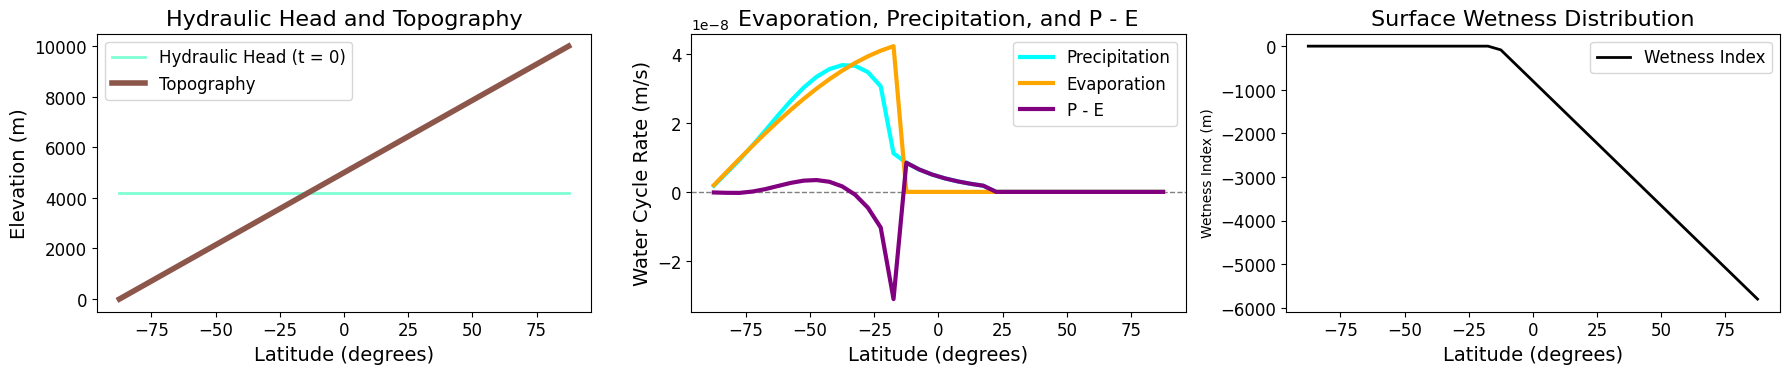

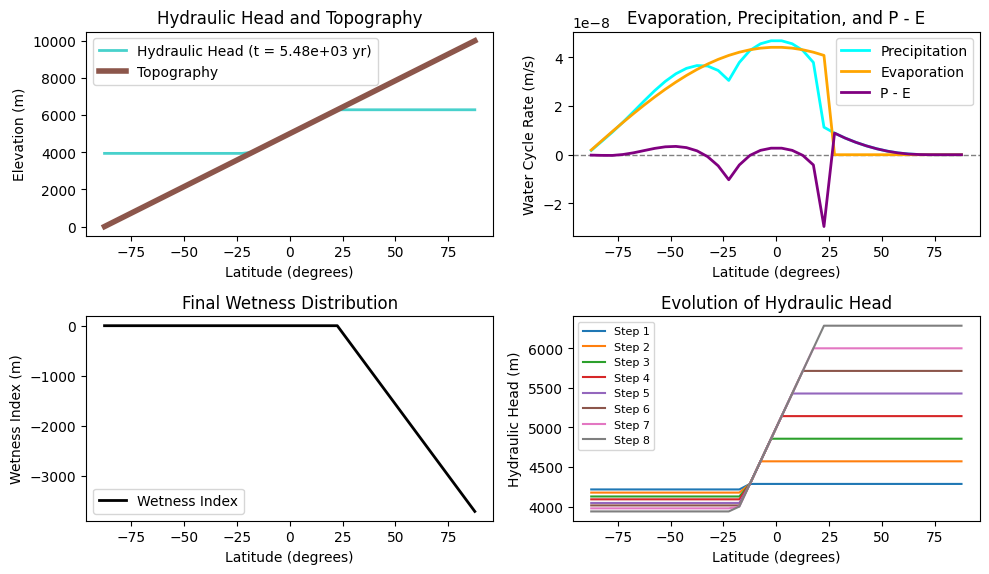

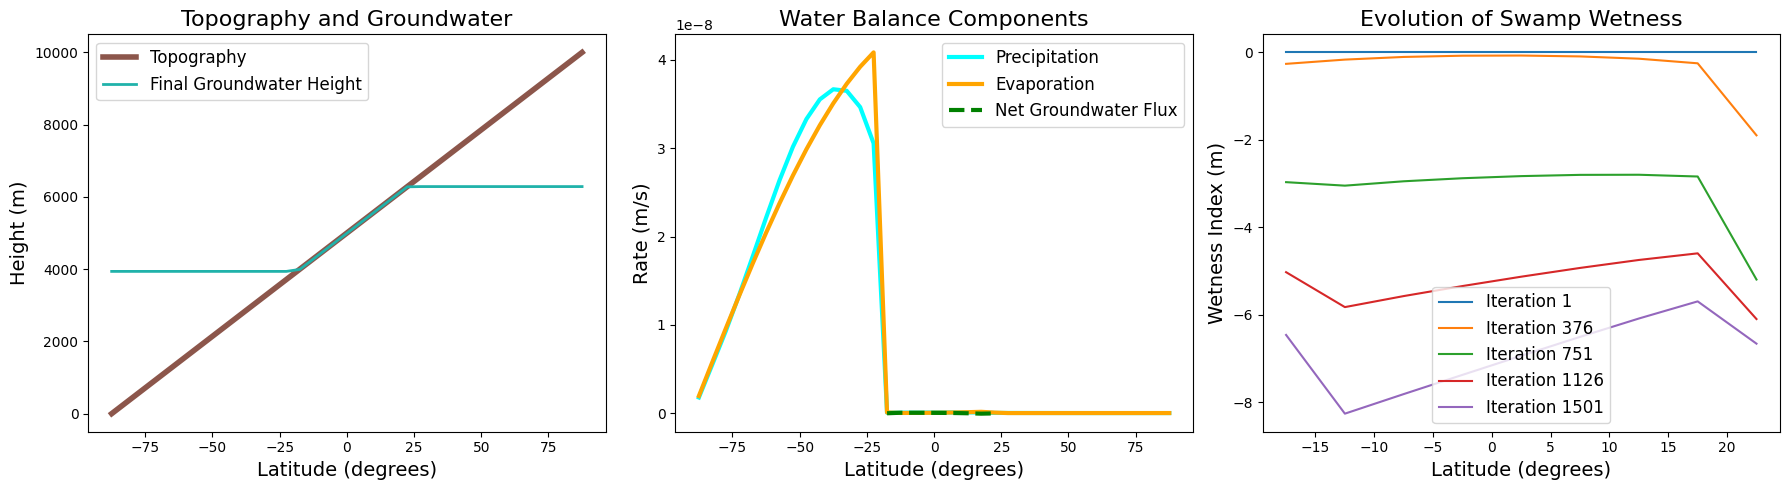

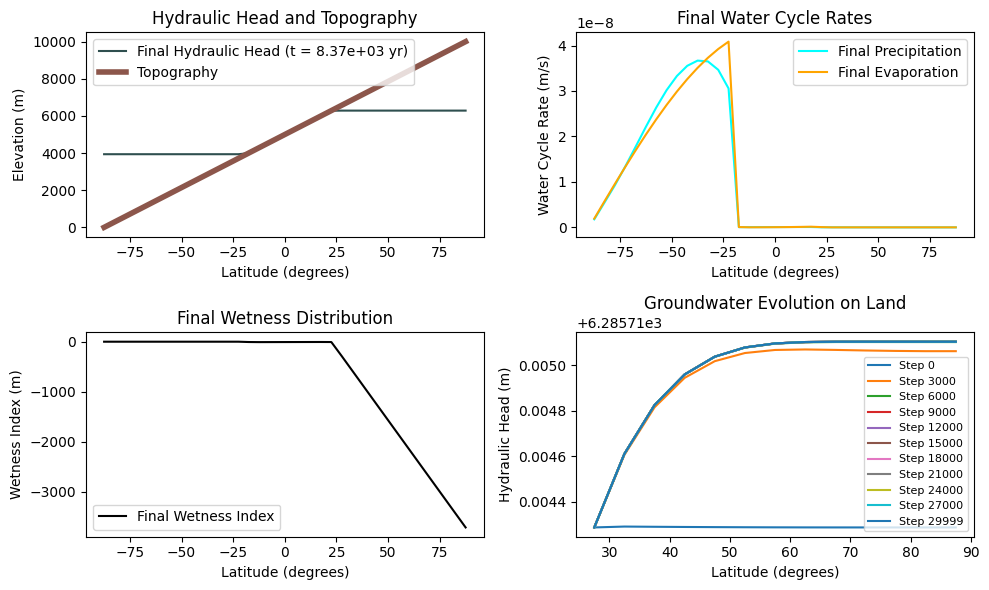

✅ Results saved successfully to hydro_K1.0e-02_GEL1000_MT20_topo_PositiveSlope_amp10000.h5

✅ Hydrological model run completed!


In [ ]:
# Step 1: Define Model Parameters
params = {
    'S': 1367 / 4,       # Solar constant in W/m²
    'r': 3.4e6,          # Planetary radius in meters
    'g': 3.7,            # Gravity in m/s²
    'K': 1e-2,           # Hydraulic conductivity in m/s
    'n_s': 0.2,          # Surface porosity
    'K_lunar': 6.5e3,    # Lunar porosity decay constant
    'g_lunar': 1.62,     # Lunar gravity
    'GEL': 1000,         # Global equivalent layer of water in meters
    'extreme_index': 1,  # Fraction of time when rainfall happens
    'moisture_transport': 20,  # ITCZ range in degrees
    'latitude_degree': 5,       # Spatial resolution in degrees
    'topo_choice': "PositiveSlope",  # Type of topography
    'topo_amplitude': 1e4           # Topographic height scale in meters
}

# Step 2: Update Derived Parameters
params = update_params(params)

# Step 3: Run the Hydrological Model
results = run_hydrological_model(params, save=True, debug = True)

In [ ]:
# Define the range of GEL values to sweep
# gel_values = list(range(10000, 999, -1000))
gel_values = list(range(1000, 199, -100))

# Define model parameters
params = {
    'S': 1367 / 4,       # Solar constant in W/m²
    'r': 3.4e6,          # Planetary radius in meters
    'g': 3.7,            # Gravity in m/s²
    'K': 1e-7,           # Hydraulic conductivity in m/s
    'n_s': 0.2,          # Surface porosity
    'K_lunar': 6.5e3,    # Lunar porosity decay constant
    'g_lunar': 1.62,     # Lunar gravity
    'GEL': 2000,         # Global equivalent layer of water in meters
    'extreme_index': 1,  # Fraction of time when rainfall happens
    'moisture_transport': 20,  # ITCZ range in degrees
    'latitude_degree': 5,       # Spatial resolution in degrees
    'topo_choice': "PositiveSlope",  # Type of topography
    'topo_amplitude': 1e3            # Topographic height scale in meters
}

# Initialize a list to store results
sweep_results = []

# Loop over each GEL value and run the hydrological model
for gel in gel_values:
    # Update the GEL parameter
    params["GEL"] = gel

    # Ensure derived parameters are updated
    params = update_params(params)

    # Print progress
    print(f"\n🚀 Running simulation for GEL = {gel:.0f} m...")

    # Run the model
    result = run_hydrological_model(params, save=True, debug=False)

    # Store the result
    sweep_results.append(result)

# Display the results
import pandas as pd
df_results = pd.DataFrame(sweep_results)



🚀 Running simulation for GEL = 1000 m...
Run out of water with surface ocean at height = 920.0 m!
Shoreline evolution completed.
Swamp evolution completed.
🏝️ Land area is too small for meaningful groundwater evolution. Skipping groundwater redistribution.

Mass Conservation Error: 0.10%
Groundwater Table Amplitude: 55.30 m
Wet Surface Fraction: 100.00%
Swamp Fraction: 1.70%
Surface Water Cycling Time: 9.14e+02 years
Groundwater Cycling Time: 7.34e+11 years
✅ Results saved successfully to hydro_K1.0e-07_GEL1000_MT20_topo_PositiveSlope_amp1000.h5

✅ Hydrological model run completed!

🚀 Running simulation for GEL = 900 m...
Run out of water with surface ocean at height = 820.0 m!
Shoreline evolution completed.
Swamp evolution completed.
🏝️ Land area is too small for meaningful groundwater evolution. Skipping groundwater redistribution.

Mass Conservation Error: 0.03%
Groundwater Table Amplitude: 171.05 m
Wet Surface Fraction: 100.00%
Swamp Fraction: 9.04%
Surface Water Cycling Time: 8.2

In [ ]:
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Collect all relevant files
files = glob.glob("hydro_K1.0e-07_GEL*_MT20_topo_PositiveSlope_amp*.h5")

# Initialize lists for data extraction
gel_list, amp_list = [], []
error_list, groundwater_amp_list = [], []
wet_surface_list, swamp_frac_list = [], []
surf_cycling_list, gw_cycling_list = [], []

# Read data from files
for file in files:
    with h5py.File(file, 'r') as f:
        try:
            gel = f['inputs'].attrs['GEL']
            amp = f['inputs'].attrs['topography_amplitude']
            error_i = f['post_processed_outputs'].attrs['error_I']
            gw_amp = f['post_processed_outputs'].attrs['groundwater_amplitude']
            wet_surface_frac = f['post_processed_outputs'].attrs['wet_surface_fraction']
            swamp_frac = f['post_processed_outputs'].attrs['swamp_fraction']
            surf_cycling = f['post_processed_outputs'].attrs['surface_cycling_time'] / 1e3  # Convert to kyrs
            gw_cycling = f['post_processed_outputs'].attrs['groundwater_cycling_time'] / 1e6  # Convert to Myrs

            # Handle extreme cycling times
            if surf_cycling > 1e8:
                surf_cycling = np.nan
            if gw_cycling > 1e8:
                gw_cycling = np.nan

            # Append data
            gel_list.append(gel)
            amp_list.append(amp)
            error_list.append(error_i * 100)  # Convert to percentage
            groundwater_amp_list.append(gw_amp)
            wet_surface_list.append(wet_surface_frac)  # Convert to percentage
            swamp_frac_list.append(swamp_frac)  # Convert to percentage
            surf_cycling_list.append(surf_cycling)
            gw_cycling_list.append(gw_cycling)

        except KeyError as e:
            print(f"Warning: Missing key {e} in file {file}. Skipping...")

# Convert to arrays and extract unique values
gel_array, amp_array = np.array(gel_list), np.array(amp_list)
error_array, groundwater_amp_array = np.array(error_list), np.array(groundwater_amp_list)
wet_surface_array, swamp_frac_array = np.array(wet_surface_list), np.array(swamp_frac_list)
surf_cycling_array, gw_cycling_array = np.array(surf_cycling_list), np.array(gw_cycling_list)

unique_gel = np.unique(gel_array)
unique_amp = np.unique(amp_array)

# Create grids and populate values
error_grid = np.full((len(unique_gel), len(unique_amp)), np.nan)
groundwater_amp_grid = np.full((len(unique_gel), len(unique_amp)), np.nan)
wet_surface_grid = np.full((len(unique_gel), len(unique_amp)), np.nan)
swamp_frac_grid = np.full((len(unique_gel), len(unique_amp)), np.nan)
surf_cycling_grid = np.full((len(unique_gel), len(unique_amp)), np.nan)
gw_cycling_grid = np.full((len(unique_gel), len(unique_amp)), np.nan)

for g, a, e, gw_amp, wet_surf, swamp_f, surf_cyc, gw_cyc in zip(
        gel_array, amp_array, error_array, groundwater_amp_array,
        wet_surface_array, swamp_frac_array, surf_cycling_array, gw_cycling_array):
    i = np.where(unique_gel == g)[0][0]
    j = np.where(unique_amp == a)[0][0]
    error_grid[i, j] = e
    groundwater_amp_grid[i, j] = gw_amp
    wet_surface_grid[i, j] = wet_surf
    swamp_frac_grid[i, j] = swamp_f
    surf_cycling_grid[i, j] = surf_cyc
    gw_cycling_grid[i, j] = gw_cyc

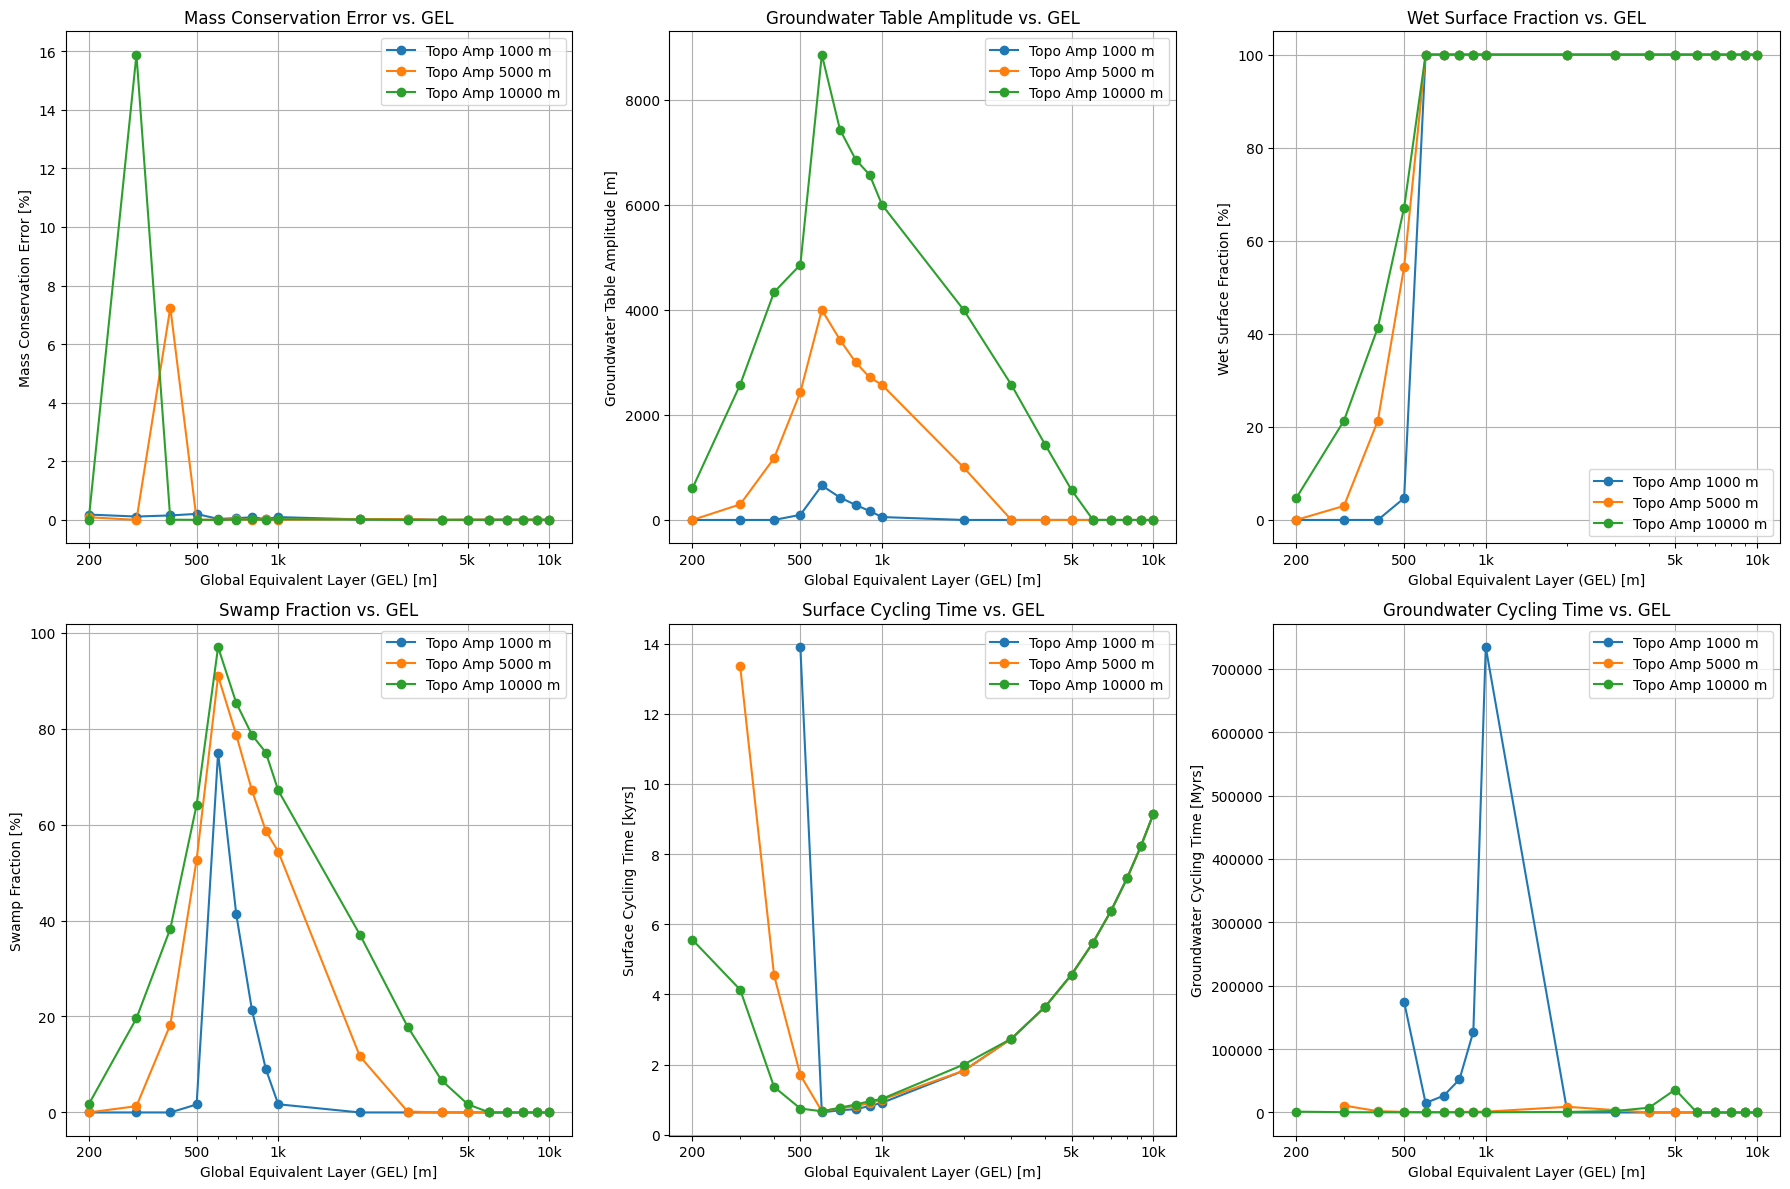

In [ ]:
# Plot all post-processed data
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# Define custom X-ticks
xticks = [200, 500, 1000, 5000, 10000]
xticklabels = ["200", "500", "1k", "5k", "10k"]

# Define a function to plot subfigures
def plot_subplot(ax, grid_data, ylabel, title, log_scale=True):
    for j, topo_amp in enumerate(unique_amp):
        valid_data = ~np.isnan(grid_data[:, j])
        if np.any(valid_data):
            ax.plot(unique_gel[valid_data], grid_data[valid_data, j], marker='o', linestyle='-', label=f"Topo Amp {topo_amp:.0f} m")
    if log_scale:
        ax.set_xscale("log")
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlabel("Global Equivalent Layer (GEL) [m]")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    ax.grid()

# Mass Conservation Error
plot_subplot(axs[0, 0], error_grid, "Mass Conservation Error [%]", "Mass Conservation Error vs. GEL")

# Groundwater Table Amplitude
plot_subplot(axs[0, 1], groundwater_amp_grid, "Groundwater Table Amplitude [m]", "Groundwater Table Amplitude vs. GEL")

# Wet Surface Fraction
plot_subplot(axs[0, 2], wet_surface_grid, "Wet Surface Fraction [%]", "Wet Surface Fraction vs. GEL")

# Swamp Fraction
plot_subplot(axs[1, 0], swamp_frac_grid, "Swamp Fraction [%]", "Swamp Fraction vs. GEL")

# Surface Cycling Time
plot_subplot(axs[1, 1], surf_cycling_grid, "Surface Cycling Time [kyrs]", "Surface Cycling Time vs. GEL")

# Groundwater Cycling Time
plot_subplot(axs[1, 2], gw_cycling_grid, "Groundwater Cycling Time [Myrs]", "Groundwater Cycling Time vs. GEL")

plt.tight_layout()
plt.show()


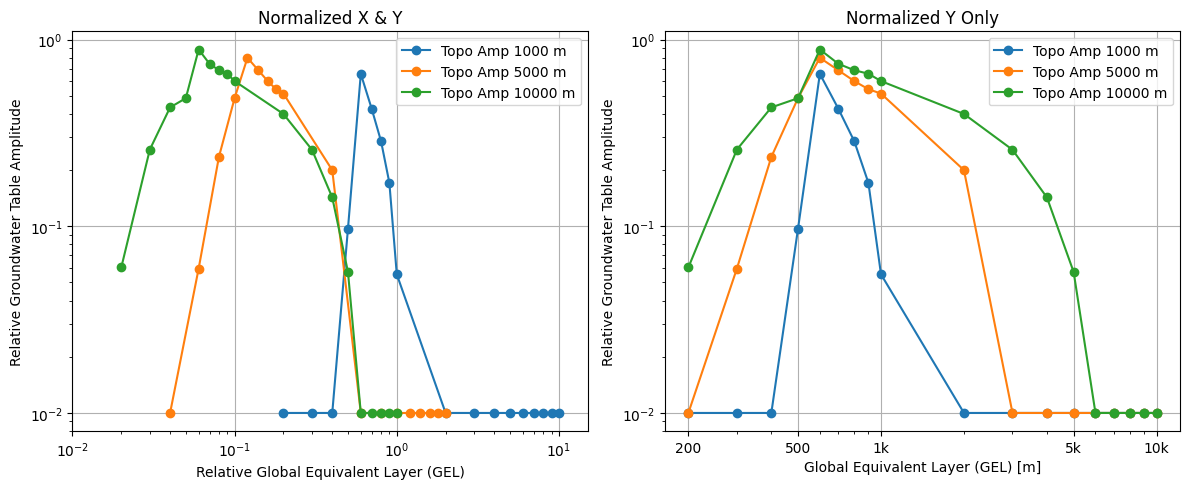

In [ ]:
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Collect all relevant files
files = glob.glob("hydro_K1.0e-07_GEL*_MT20_topo_PositiveSlope_amp*.h5")

# Initialize lists for data extraction
gel_list = []
amp_list = []
groundwater_amp_list = []

# Read data from files
for file in files:
    with h5py.File(file, 'r') as f:
        try:
            gel = f['inputs'].attrs['GEL']
            amp = f['inputs'].attrs['topography_amplitude']
            groundwater_amp = f['post_processed_outputs'].attrs['groundwater_amplitude']

            gel_list.append(gel)
            amp_list.append(amp)
            groundwater_amp_list.append(groundwater_amp)
        except KeyError as e:
            print(f"Warning: Missing key {e} in file {file}. Skipping...")

# Convert to arrays and extract unique values
gel_array = np.array(gel_list)
amp_array = np.array(amp_list)
groundwater_amp_array = np.array(groundwater_amp_list)

unique_gel = np.unique(gel_array)
unique_amp = np.unique(amp_array)

# Create grid and populate values
groundwater_amp_grid = np.full((len(unique_gel), len(unique_amp)), np.nan)

for g, a, ga in zip(gel_array, amp_array, groundwater_amp_array):
    i = np.where(unique_gel == g)[0][0]
    j = np.where(unique_amp == a)[0][0]
    groundwater_amp_grid[i, j] = ga

# ✅ Define lower limit for normalized groundwater amplitude
y_min_plot = 1e-2   # Minimum normalized value for log-scale plotting

# **Panel 1: Normalize X (GEL) and Y (Groundwater Amplitude) by Topo Amplitude**
normalized_gel = unique_gel[:, None] / unique_amp  # Normalize each GEL value by the corresponding topo amplitude
normalized_groundwater_amp = groundwater_amp_grid / unique_amp  # Normalize amplitude by topo amplitude

# ✅ Apply lower limit
normalized_groundwater_amp[normalized_groundwater_amp < y_min_plot] = y_min_plot

# **Panel 2: Normalize only Y (Groundwater Amplitude)**
absolute_gel = unique_gel[:, None]  # Keep GEL absolute
normalized_only_Y = groundwater_amp_grid / unique_amp  # Normalize Y only

# ✅ Apply lower limit
normalized_only_Y[normalized_only_Y < y_min_plot] = y_min_plot

# **Create dual-panel figure**
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# **Panel 1: Normalize X and Y**
for j, topo_amp in enumerate(unique_amp):
    valid_data = ~np.isnan(normalized_groundwater_amp[:, j])
    if np.any(valid_data):
        axs[0].plot(normalized_gel[valid_data, j], normalized_groundwater_amp[valid_data, j],
                    marker='o', linestyle='-', label=f"Topo Amp {topo_amp:.0f} m")

axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlim(1e-2, 1.5e1)
axs[0].set_xlabel("Relative Global Equivalent Layer (GEL)")
axs[0].set_ylabel("Relative Groundwater Table Amplitude")
axs[0].set_title("Normalized X & Y")
axs[0].legend()
axs[0].grid()

# **Panel 2: Normalize only Y (Absolute X)**
for j, topo_amp in enumerate(unique_amp):
    valid_data = ~np.isnan(normalized_only_Y[:, j])
    if np.any(valid_data):
        axs[1].plot(unique_gel[valid_data], normalized_only_Y[valid_data, j],
                    marker='o', linestyle='-', label=f"Topo Amp {topo_amp:.0f} m")

axs[1].set_xscale("log")
axs[1].set_yscale("log")
# axs[1].set_xlim(200, 10000)
axs[1].set_xticks([200, 500, 1000, 5000, 10000])
axs[1].set_xticklabels(["200", "500", "1k", "5k", "10k"])
axs[1].set_xlabel("Global Equivalent Layer (GEL) [m]")
axs[1].set_ylabel("Relative Groundwater Table Amplitude")
axs[1].set_title("Normalized Y Only")
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()


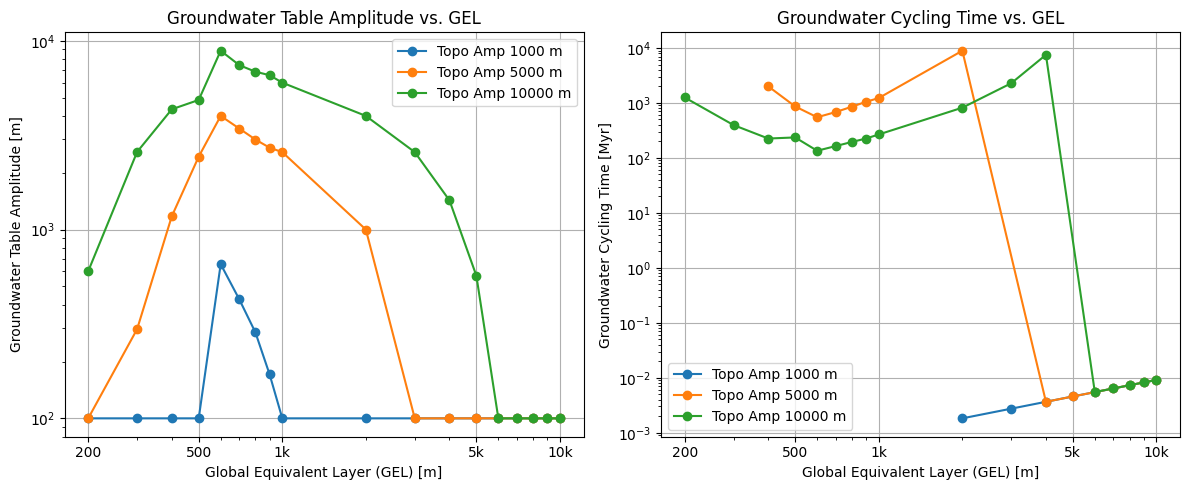

In [ ]:
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Collect all relevant files
files = glob.glob("hydro_K1.0e-07_GEL*_MT20_topo_PositiveSlope_amp*.h5")

# Initialize lists for data extraction
gel_list = []
amp_list = []
groundwater_amp_list = []
groundwater_cycling_list = []

# Read data from files
for file in files:
    with h5py.File(file, 'r') as f:
        try:
            gel = f['inputs'].attrs['GEL']
            amp = f['inputs'].attrs['topography_amplitude']
            groundwater_amp = f['post_processed_outputs'].attrs['groundwater_amplitude']
            groundwater_cycling = f['post_processed_outputs'].attrs['groundwater_cycling_time']

            gel_list.append(gel)
            amp_list.append(amp)
            groundwater_amp_list.append(groundwater_amp)
            groundwater_cycling_list.append(groundwater_cycling)
        except KeyError as e:
            print(f"Warning: Missing key {e} in file {file}. Skipping...")

# Convert to arrays and extract unique values
gel_array = np.array(gel_list)
amp_array = np.array(amp_list)
groundwater_amp_array = np.array(groundwater_amp_list)
groundwater_cycling_array = np.array(groundwater_cycling_list)

unique_gel = np.unique(gel_array)
unique_amp = np.unique(amp_array)

# Create grids and populate values
groundwater_amp_grid = np.full((len(unique_gel), len(unique_amp)), np.nan)
groundwater_cycling_grid = np.full((len(unique_gel), len(unique_amp)), np.nan)

for g, a, ga, gc in zip(gel_array, amp_array, groundwater_amp_array, groundwater_cycling_array):
    i = np.where(unique_gel == g)[0][0]
    j = np.where(unique_amp == a)[0][0]
    groundwater_amp_grid[i, j] = ga
    groundwater_cycling_grid[i, j] = gc

# ✅ Define different lower & upper limits
y_min_amp = 1.0e+2  # Lower limit for Groundwater Table Amplitude [meters] (100 m)
y_min_cycle = 1e3   # Lower limit for Groundwater Cycling Time [years] (1 kyrs)
y_max_cycle = 10e9   # Maximum for Groundwater Cycling Time [years] (4 Gyrs)

# ✅ Apply different lower & upper limits
groundwater_amp_grid[groundwater_amp_grid < y_min_amp] = y_min_amp
groundwater_cycling_grid[groundwater_cycling_grid < y_min_cycle] = y_min_cycle
groundwater_cycling_grid[groundwater_cycling_grid > y_max_cycle] = np.nan  # Remove unrealistic values

# Plot only the 2nd and 6th panels (Groundwater Amplitude & Groundwater Cycling Time)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# **Panel 1: Groundwater Table Amplitude**
for j, topo_amp in enumerate(unique_amp):
    valid_data = ~np.isnan(groundwater_amp_grid[:, j])
    if np.any(valid_data):
        axs[0].plot(unique_gel[valid_data], groundwater_amp_grid[valid_data, j], marker='o', linestyle='-', label=f"Topo Amp {topo_amp:.0f} m")

axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xticks([200, 500, 1000, 5000, 10000])
axs[0].set_xticklabels(["200", "500", "1k", "5k", "10k"])
axs[0].set_xlabel("Global Equivalent Layer (GEL) [m]")
axs[0].set_ylabel("Groundwater Table Amplitude [m]")
axs[0].set_title("Groundwater Table Amplitude vs. GEL")
axs[0].legend()
axs[0].grid()

# **Panel 2: Groundwater Cycling Time**
for j, topo_amp in enumerate(unique_amp):
    valid_data = ~np.isnan(groundwater_cycling_grid[:, j])
    if np.any(valid_data):
        axs[1].plot(unique_gel[valid_data], groundwater_cycling_grid[valid_data, j] / 1e6, marker='o', linestyle='-', label=f"Topo Amp {topo_amp:.0f} m")  # Convert to Myrs

axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_xticks([200, 500, 1000, 5000, 10000])
axs[1].set_xticklabels(["200", "500", "1k", "5k", "10k"])
axs[1].set_xlabel("Global Equivalent Layer (GEL) [m]")
axs[1].set_ylabel("Groundwater Cycling Time [Myr]")
axs[1].set_title("Groundwater Cycling Time vs. GEL")
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()


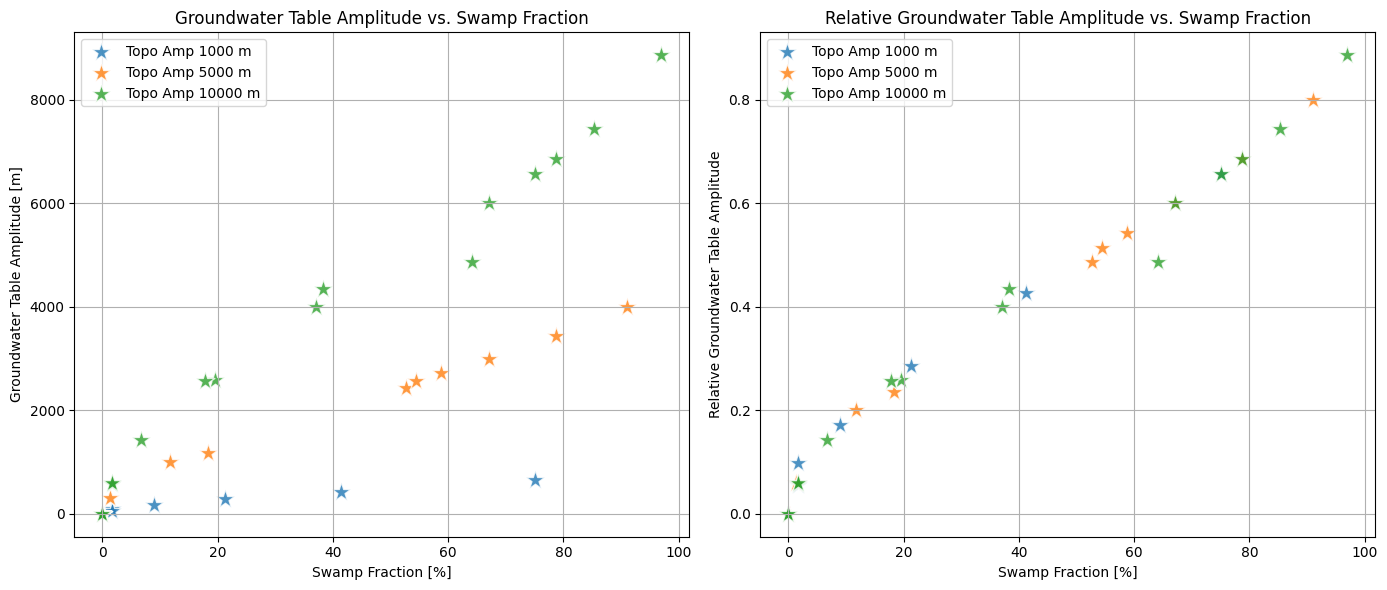

In [ ]:
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Collect all relevant files
files = glob.glob("hydro_K1.0e-07_GEL*_MT20_topo_PositiveSlope_amp*.h5")

# Initialize lists for data extraction
amp_list = []
swamp_frac_list = []
groundwater_amp_list = []

# Read data from files
for file in files:
    with h5py.File(file, 'r') as f:
        try:
            amp = f['inputs'].attrs['topography_amplitude']
            swamp_frac = f['post_processed_outputs'].attrs['swamp_fraction']
            groundwater_amp = f['post_processed_outputs'].attrs['groundwater_amplitude']

            amp_list.append(amp)
            swamp_frac_list.append(swamp_frac)
            groundwater_amp_list.append(groundwater_amp)

        except KeyError as e:
            print(f"Warning: Missing key {e} in file {file}. Skipping...")

# Convert to NumPy arrays
amp_array = np.array(amp_list)
swamp_frac_array = np.array(swamp_frac_list)
groundwater_amp_array = np.array(groundwater_amp_list)

# **Compute Relative Groundwater Table Amplitude**
relative_groundwater_amp_array = groundwater_amp_array / amp_array

# Extract unique topo amplitudes
unique_amp = np.unique(amp_array)

# **Create a figure with two panels**
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# **Panel 1: Absolute Groundwater Table Amplitude vs. Swamp Fraction**
for topo_amp in unique_amp:
    valid_data = amp_array == topo_amp
    if np.any(valid_data):
        axs[0].scatter(swamp_frac_array[valid_data], groundwater_amp_array[valid_data],
                       marker="*", s=200, edgecolors="w", alpha=0.8, label=f"Topo Amp {topo_amp:.0f} m")

axs[0].set_xlabel("Swamp Fraction [%]")
axs[0].set_ylabel("Groundwater Table Amplitude [m]")
axs[0].set_title("Groundwater Table Amplitude vs. Swamp Fraction")
axs[0].legend()
axs[0].grid()

# **Panel 2: Relative Groundwater Table Amplitude vs. Swamp Fraction**
for topo_amp in unique_amp:
    valid_data = amp_array == topo_amp
    if np.any(valid_data):
        axs[1].scatter(swamp_frac_array[valid_data], relative_groundwater_amp_array[valid_data],
                       marker="*", s=200, edgecolors="w", alpha=0.8, label=f"Topo Amp {topo_amp:.0f} m")

axs[1].set_xlabel("Swamp Fraction [%]")
axs[1].set_ylabel("Relative Groundwater Table Amplitude")
axs[1].set_title("Relative Groundwater Table Amplitude vs. Swamp Fraction")
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()


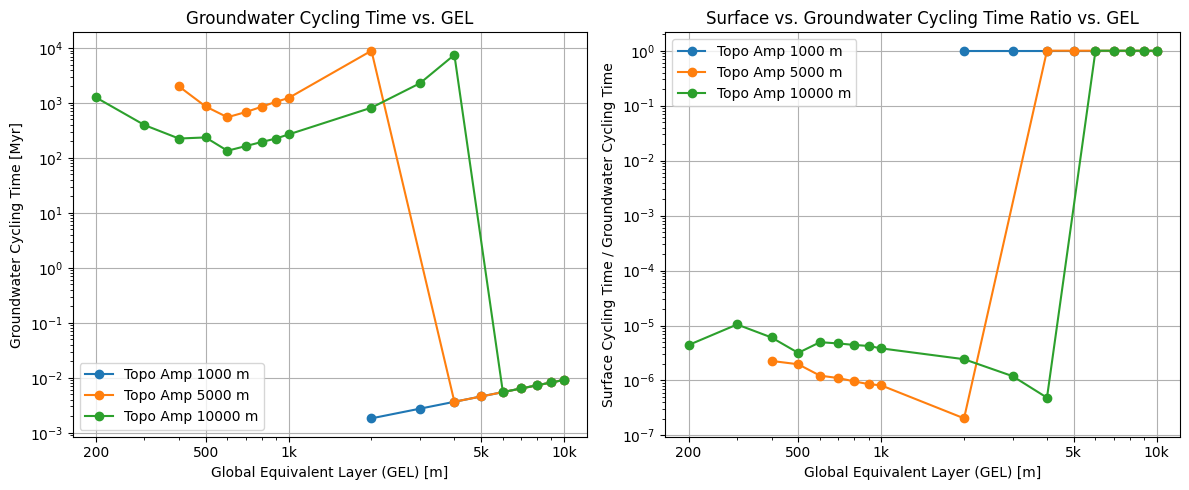

In [ ]:
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Collect all relevant files
files = glob.glob("hydro_K1.0e-07_GEL*_MT20_topo_PositiveSlope_amp*.h5")

# Initialize lists for data extraction
gel_list = []
amp_list = []
groundwater_cycling_list = []
surf_cycling_list = []
gw_cycling_list = []

# Read data from files
for file in files:
    with h5py.File(file, 'r') as f:
        try:
            gel = f['inputs'].attrs['GEL']
            amp = f['inputs'].attrs['topography_amplitude']
            groundwater_cycling = f['post_processed_outputs'].attrs['groundwater_cycling_time']
            surf_cycling = f['post_processed_outputs'].attrs['surface_cycling_time']
            gw_cycling = f['post_processed_outputs'].attrs['groundwater_cycling_time']

            # ✅ Exclude only extreme groundwater cycling times (> 1e10 years)
            if groundwater_cycling > 1e10:
                groundwater_cycling = np.nan
            if gw_cycling > 1e10:
                gw_cycling = np.nan

            gel_list.append(gel)
            amp_list.append(amp)
            groundwater_cycling_list.append(groundwater_cycling)
            surf_cycling_list.append(surf_cycling)
            gw_cycling_list.append(gw_cycling)

        except KeyError as e:
            print(f"Warning: Missing key {e} in file {file}. Skipping...")

# Convert to arrays and extract unique values
gel_array = np.array(gel_list)
amp_array = np.array(amp_list)
groundwater_cycling_array = np.array(groundwater_cycling_list)
surf_cycling_array = np.array(surf_cycling_list)
gw_cycling_array = np.array(gw_cycling_list)

# **Compute the Surface / Groundwater Cycling Ratio**
cycling_ratio_array = surf_cycling_array / gw_cycling_array  # Ratio

# Extract unique values
unique_gel = np.unique(gel_array)
unique_amp = np.unique(amp_array)

# Create grids
groundwater_cycling_grid = np.full((len(unique_gel), len(unique_amp)), np.nan)
cycling_ratio_grid = np.full((len(unique_gel), len(unique_amp)), np.nan)

for g, a, gc, cr in zip(gel_array, amp_array, groundwater_cycling_array, cycling_ratio_array):
    i = np.where(unique_gel == g)[0][0]
    j = np.where(unique_amp == a)[0][0]
    groundwater_cycling_grid[i, j] = gc
    cycling_ratio_grid[i, j] = cr

# **Plot Groundwater Cycling Time vs. GEL (Panel 1) and Cycling Ratio vs. GEL (Panel 2)**
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# **Panel 1: Groundwater Cycling Time**
for j, topo_amp in enumerate(unique_amp):
    valid_data = ~np.isnan(groundwater_cycling_grid[:, j])
    if np.any(valid_data):
        axs[0].plot(unique_gel[valid_data], groundwater_cycling_grid[valid_data, j] / 1e6,
                    marker='o', linestyle='-', label=f"Topo Amp {topo_amp:.0f} m")  # Convert to Myrs

axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xticks([200, 500, 1000, 5000, 10000])
axs[0].set_xticklabels(["200", "500", "1k", "5k", "10k"])
axs[0].set_xlabel("Global Equivalent Layer (GEL) [m]")
axs[0].set_ylabel("Groundwater Cycling Time [Myr]")
axs[0].set_title("Groundwater Cycling Time vs. GEL")
axs[0].legend()
axs[0].grid()

# **Panel 2: Surface Cycling Time / Groundwater Cycling Time**
for j, topo_amp in enumerate(unique_amp):
    valid_data = ~np.isnan(cycling_ratio_grid[:, j])
    if np.any(valid_data):
        axs[1].plot(unique_gel[valid_data], cycling_ratio_grid[valid_data, j],
                    marker='o', linestyle='-', label=f"Topo Amp {topo_amp:.0f} m")

axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_xticks([200, 500, 1000, 5000, 10000])
axs[1].set_xticklabels(["200", "500", "1k", "5k", "10k"])
axs[1].set_xlabel("Global Equivalent Layer (GEL) [m]")
axs[1].set_ylabel("Surface Cycling Time / Groundwater Cycling Time")
axs[1].set_title("Surface vs. Groundwater Cycling Time Ratio vs. GEL")
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()


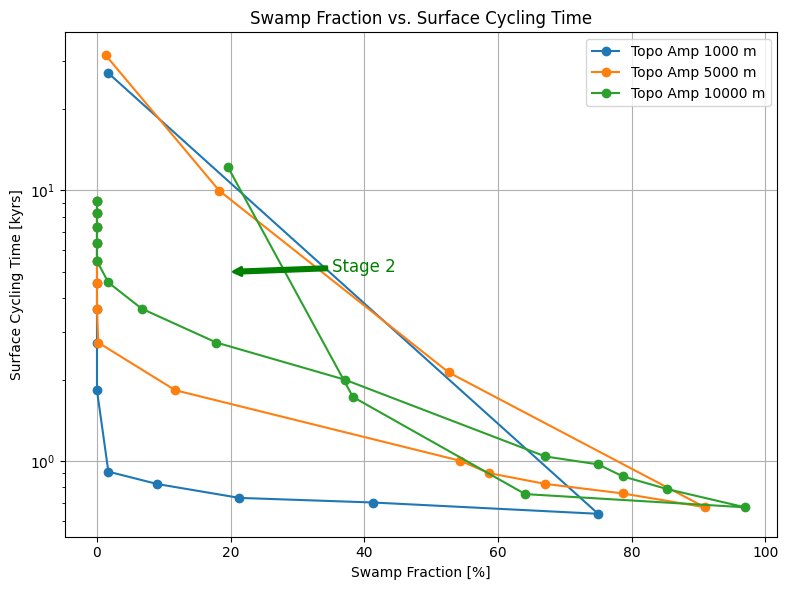

In [ ]:
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Collect all relevant files
files = glob.glob("hydro_K1.0e-05_GEL*_MT20_topo_PositiveSlope_amp*.h5")

# Initialize lists for data extraction
gel_list = []
amp_list = []
swamp_frac_list = []
surf_cycling_list = []

# Read data from files
for file in files:
    with h5py.File(file, 'r') as f:
        try:
            gel = f['inputs'].attrs['GEL']
            amp = f['inputs'].attrs['topography_amplitude']
            swamp_frac = f['post_processed_outputs'].attrs['swamp_fraction']
            surf_cycling = f['post_processed_outputs'].attrs['surface_cycling_time']

            # Handle extreme cycling times
            if surf_cycling > 1e8:
                surf_cycling = np.nan

            gel_list.append(gel)
            amp_list.append(amp)
            swamp_frac_list.append(swamp_frac)
            surf_cycling_list.append(surf_cycling)

        except KeyError as e:
            print(f"Warning: Missing key {e} in file {file}. Skipping...")

# Convert to arrays
gel_array = np.array(gel_list)
amp_array = np.array(amp_list)
swamp_frac_array = np.array(swamp_frac_list)
surf_cycling_array = np.array(surf_cycling_list)

# ✅ **Exclude the specific case before reshaping**
exclude_mask = (gel_array == 200) & (amp_array == 10000)

gel_array = gel_array[~exclude_mask]
amp_array = amp_array[~exclude_mask]
swamp_frac_array = swamp_frac_array[~exclude_mask]
surf_cycling_array = surf_cycling_array[~exclude_mask]

# Extract unique values
unique_gel = np.unique(gel_array)
unique_amp = np.unique(amp_array)

# Create grids
swamp_frac_grid = np.full((len(unique_gel), len(unique_amp)), np.nan)
surf_cycling_grid = np.full((len(unique_gel), len(unique_amp)), np.nan)

for g, a, sf, sc in zip(gel_array, amp_array, swamp_frac_array, surf_cycling_array):
    i = np.where(unique_gel == g)[0][0]
    j = np.where(unique_amp == a)[0][0]
    swamp_frac_grid[i, j] = sf
    surf_cycling_grid[i, j] = sc

# **Plot Swamp Fraction vs. Surface Cycling Time for Different Topographic Amplitudes**
fig, ax = plt.subplots(figsize=(8, 6))

for j, topo_amp in enumerate(unique_amp):
    valid_data = ~np.isnan(swamp_frac_grid[:, j]) & ~np.isnan(surf_cycling_grid[:, j])

    if np.any(valid_data):
        ax.plot(swamp_frac_grid[valid_data, j], surf_cycling_grid[valid_data, j] / 1e3,
                marker='o', linestyle='-', label=f"Topo Amp {topo_amp:.0f} m")

# ✅ Log scale for Y-axis (Surface Cycling Time)
ax.set_yscale("log")

# Labels and Title
ax.set_xlabel("Swamp Fraction [%]")
ax.set_ylabel("Surface Cycling Time [kyrs]")
ax.set_title("Swamp Fraction vs. Surface Cycling Time")
ax.legend()
ax.grid()

# **🎯 Add Properly Styled Arrows and Stage Labels**

# Stage 1: Downward arrow (Near Y-axis)
ax.annotate("Stage 1", xy=(0.02, 1e6), xytext=(0.02, 3e6),  # Adjusted positions
            arrowprops=dict(facecolor="blue", edgecolor="blue", arrowstyle="simple", lw=2),
            fontsize=12, color="blue", ha="center")

# Stage 2: Rightward arrow (Near X-axis)
ax.annotate("Stage 2", xy=(20, 5), xytext=(40, 5),  # Adjusted positions
            arrowprops=dict(facecolor="green", edgecolor="green", arrowstyle="simple", lw=2),
            fontsize=12, color="green", ha="center")

# Stage 3: Diagonal arrow (Bottom-right to Top-left)
ax.annotate("Stage 3", xy=(70, 1e3), xytext=(30, 1e6),  # Adjusted positions
            arrowprops=dict(facecolor="red", edgecolor="red", arrowstyle="->", lw=2),
            fontsize=12, color="red", ha="center")

plt.tight_layout()
plt.show()


In [ ]:
with h5py.File("hydro_K1.0e-02_GEL5000_MT20_topo_PositiveSlope_amp10000.h5", "r") as f:
    print("Input Parameters:")
    for key, value in f["inputs"].attrs.items():
        print(f"{key}: {value}")

    print("\nPost-Processed Outputs:")
    for key, value in f["post_processed_outputs"].attrs.items():
        print(f"{key}: {value}")

    final_head = np.array(f["raw_outputs/final_head"])
    final_wetness = np.array(f["raw_outputs/final_wetness"])


Input Parameters:
GEL: 5000
GEL_unit: m
K: 0.01
K_unit: m/s
moisture_transport: 20
moisture_transport_unit: degrees
topography_amplitude: 10000.0
topography_amplitude_unit: m
topography_choice: PositiveSlope

Post-Processed Outputs:
error_I: 0.00016638890665349358
error_I_unit: dimensionless
groundwater_amplitude: 0.0
groundwater_amplitude_unit: m
groundwater_cycling_time: nan
groundwater_cycling_time_unit: years
surface_cycling_time: 4571.02384998391
surface_cycling_time_unit: years
swamp_fraction: 0.0
swamp_fraction_unit: %
wet_surface_fraction: 99.2403876506104
wet_surface_fraction_unit: %


In [ ]:
# print(shoreline_h_evolution)

[]
